<a href="https://colab.research.google.com/github/MarioSigal/Elementos-de-Reconocimiento-Visual/blob/main/Tareas/Tarea2_Categorizador_de_Ambientes_BOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Nombre del Grupo*: Nosotres

*Integrantes*: Lautaro masetto, Matias Halperin, Leonardo Dominguez, Mario Sigal Aguirre

# **Tarea 2: Categorizador de Ambientes usando Bag of Words**


Como vieron en la clase anterior, podemos utilizar el algoritmo de Bag of Words para encontrar similitudes entre el contenido de distintas imagenes detectando si contienen puntos claves semejantes. Esto nos permite hablar de forma mas abstracta sobre nuestras imagenes, concentrandonos en su escena mas que en su forma, es decir, el vocabulario creado por Bag of Word nos brinda un lenguaje comun para hablar de escenas que una computadora puede entender.

Para esta Tarea tendran que utilizar el algoritmo de Bag of Words para clasificar 5 escenas distintas. Las escenas constaran de los siguientes paisajes:

🏜️ **Desierto** | 🌲 **Bosque** | 🧊 **Glaciar** | ⛰️ **Montaña** | 🏖 **Costa**

Luego de crear un clasificador, deberan analizar los siguientes aspectos de su implementacion:

- Comprender el impacto de diferentes parámetros en el rendimiento
- Analizar qué características visuales son más discriminativas
- Evaluar las limitaciones del método en casos reales

## **Dataset Proporcionado**

Para crear su corpus de features se les proporcionará un dataset balanceado con:
- **$≈$600 imágenes por categoría** (3433 total)
- **Train:** $≈$500 imágenes por categoría (2913 total)
- **Test:** $≈$100 imágenes por categoría (520 total)

El DataSet puede encontrarse en Drive por el siguiente Link: [DATASET](https://drive.google.com/drive/folders/1PlpoATt1zt_Q21v3x08tIWA5NZ-EDpAI?usp=sharing)

El cual es un subset curado de un DataSet de Kaggle con 12K imagenes: [DATASET COMPLETO](https://www.kaggle.com/datasets/utkarshsaxenadn/landscape-recognition-image-dataset-12k-images)

## **Implementacion**

### ***Set Up***

In [ ]:
!pip3 install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 32.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread
from skimage.feature import SIFT
from skimage.transform import resize

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import time
import glob
import os
from tqdm.notebook import tqdm
import warnings
import math
import random

warnings.filterwarnings('ignore')

# Configuración para gráficos
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


### ***UTIL***

In [ ]:
def indicesDeCategoriaEnLista(etiquetas, categoria):
  """Devuelve los indices donde la etiqueta sea igual que la categoria"""
  return [j for j, etiq in enumerate(etiquetas) if etiq == categoria]

def indexadoIndirecto(idx, lista_indices, lista_principal):
  """Devuelve el resultado de indexar indirectamente una lista"""
  return lista_principal[lista_indices[idx]]

### ***1. Carga y Exploración del Dataset***

**Uso del Drive**

Al tratarse de un dataset con tantos elementos, recomendamos utilizar el dataset directamente desde drive en vez de cargarlo cada vez que quieran trabajar con el. Intenten que todos los participantes del grupo lo tengan en el misma direccion para hacer mas fluido su trabajo.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def pathDeArchivoPorCategoria(data_path, categoria):
  """
  Devuelve la direccion de todos las imagenes en la carpeta de la categoria

  Returns:
    archivos: una lista con cada una de las direcciones de archivos.
  """

  categoria_path = os.path.join(data_path, categoria)

  archivos = glob.glob(os.path.join(categoria_path, "*.jpg")) + \
             glob.glob(os.path.join(categoria_path, "*.jpeg")) + \
             glob.glob(os.path.join(categoria_path, "*.png"))

  return archivos

def cargarImagenPorArchivo(archivo):
  """
  Devuelve la imagen cargada en blanco y negro, habiendo sido reescalada si fuera necesario.

  Returns:
    img: La imgen cargada por Archivo.
  """

  img = imread(archivo, as_gray=True)

  # Redimensionar si es necesario (opcional)
  if img.shape[0] > 400 or img.shape[1] > 400:
    img = resize(img, (300, 300), anti_aliasing=True)

  return img

In [ ]:
def cargarDataSet(data_path, categorias):
  """
  Carga todas las imágenes del dataset organizadas por categoría

  Returns:
    imagenes: lista de imágenes en escala de grises
    etiquetas: lista de etiquetas correspondientes
    nombres_archivo: lista con nombres de archivos para referencia
  """

  imagenes = []
  etiquetas = []
  nombres_archivo = []

  print(f"Cargando dataset desde: {data_path}")

  # Cargamos las imagenes de cada Categoria
  for categoria in categorias:

    archivos = pathDeArchivoPorCategoria(data_path, categoria)

    print(f"  {categoria}: {len(archivos)} imágenes")

    for archivo in tqdm(archivos, desc=f"Cargando {categoria}"):

      try:
        img = cargarImagenPorArchivo(archivo)
        imagenes.append(img)
        etiquetas.append(categoria)
        nombres_archivo.append(os.path.basename(archivo))

      except Exception as e:
        print(f"Error cargando {archivo}: {e}")

  return imagenes, etiquetas, nombres_archivo


***CARGA***

In [ ]:
# Definir categorías de ambientes
CATEGORIAS = ['Desert', 'Forest', 'Glacier', 'Mountain', 'Coast']
COLORES_CATEGORIAS = ['#D4A574', '#228B22', '#87CEEB', '#696969', '#87CEEB']

# Paths del dataset
DATA_PATH = "/content/drive/MyDrive/DataSetsNature/"
TRAIN_PATH = os.path.join(DATA_PATH, "Training Data")
TEST_PATH = os.path.join(DATA_PATH, "Testing Data")

# Cargar datasets de entrenamiento y prueba
print("=" * 50)
print("CARGANDO DATASET DE ENTRENAMIENTO")
print("=" * 50)
imagenes_train, etiquetas_train, nombres_train = cargarDataSet(TRAIN_PATH, CATEGORIAS)

print("\n" + "=" * 50)
print("CARGANDO DATASET DE PRUEBA")
print("=" * 50)
imagenes_test, etiquetas_test, nombres_test = cargarDataSet(TEST_PATH, CATEGORIAS)

print(f"\n📊 RESUMEN DEL DATASET:")
print(f"Training: {len(imagenes_train)} imágenes")
print(f"Testing: {len(imagenes_test)} imágenes")
print(f"Total: {len(imagenes_train) + len(imagenes_test)} imágenes")

CARGANDO DATASET DE ENTRENAMIENTO
Cargando dataset desde: /content/drive/MyDrive/DataSetsNature/Training Data
  Desert: 639 imágenes


Cargando Desert:   0%|          | 0/639 [00:00<?, ?it/s]

  Forest: 651 imágenes


Cargando Forest:   0%|          | 0/651 [00:00<?, ?it/s]

  Glacier: 500 imágenes


Cargando Glacier:   0%|          | 0/500 [00:00<?, ?it/s]

  Mountain: 500 imágenes


Cargando Mountain:   0%|          | 0/500 [00:00<?, ?it/s]

  Coast: 623 imágenes


Cargando Coast:   0%|          | 0/623 [00:00<?, ?it/s]


CARGANDO DATASET DE PRUEBA
Cargando dataset desde: /content/drive/MyDrive/DataSetsNature/Testing Data
  Desert: 100 imágenes


Cargando Desert:   0%|          | 0/100 [00:00<?, ?it/s]

  Forest: 100 imágenes


Cargando Forest:   0%|          | 0/100 [00:00<?, ?it/s]

  Glacier: 120 imágenes


Cargando Glacier:   0%|          | 0/120 [00:00<?, ?it/s]

  Mountain: 100 imágenes


Cargando Mountain:   0%|          | 0/100 [00:00<?, ?it/s]

  Coast: 100 imágenes


Cargando Coast:   0%|          | 0/100 [00:00<?, ?it/s]


📊 RESUMEN DEL DATASET:
Training: 2913 imágenes
Testing: 520 imágenes
Total: 3433 imágenes


***VISUALIZACION***

In [ ]:
# Visualización de ejemplos del dataset
def mostrarEjemplosDataSet(imagenes, etiquetas, categorias, n_ejemplos=2):
  """Muestra ejemplos de cada categoría del dataset"""

  fig, axes = plt.subplots(len(categorias), n_ejemplos, figsize=(15, 12))
  fig.suptitle('Ejemplos del Dataset por Categoría', fontsize=16, fontweight='bold')

  for i, categoria in enumerate(categorias):
    # Encontrar índices de esta categoría
    indices_categoria = indicesDeCategoriaEnLista(etiquetas, categoria)
    random.shuffle(indices_categoria)

    # Mostramos imagenes de Ejemplos por categoria
    for j in range(n_ejemplos):

        img = indexadoIndirecto(j, indices_categoria, imagenes)
        axes[i, j].imshow(img, cmap='gray', clim=(0,1))
        axes[i, j].set_title(f'{categoria}', fontweight='bold')
        axes[i, j].axis('off')

  plt.tight_layout()
  plt.show()

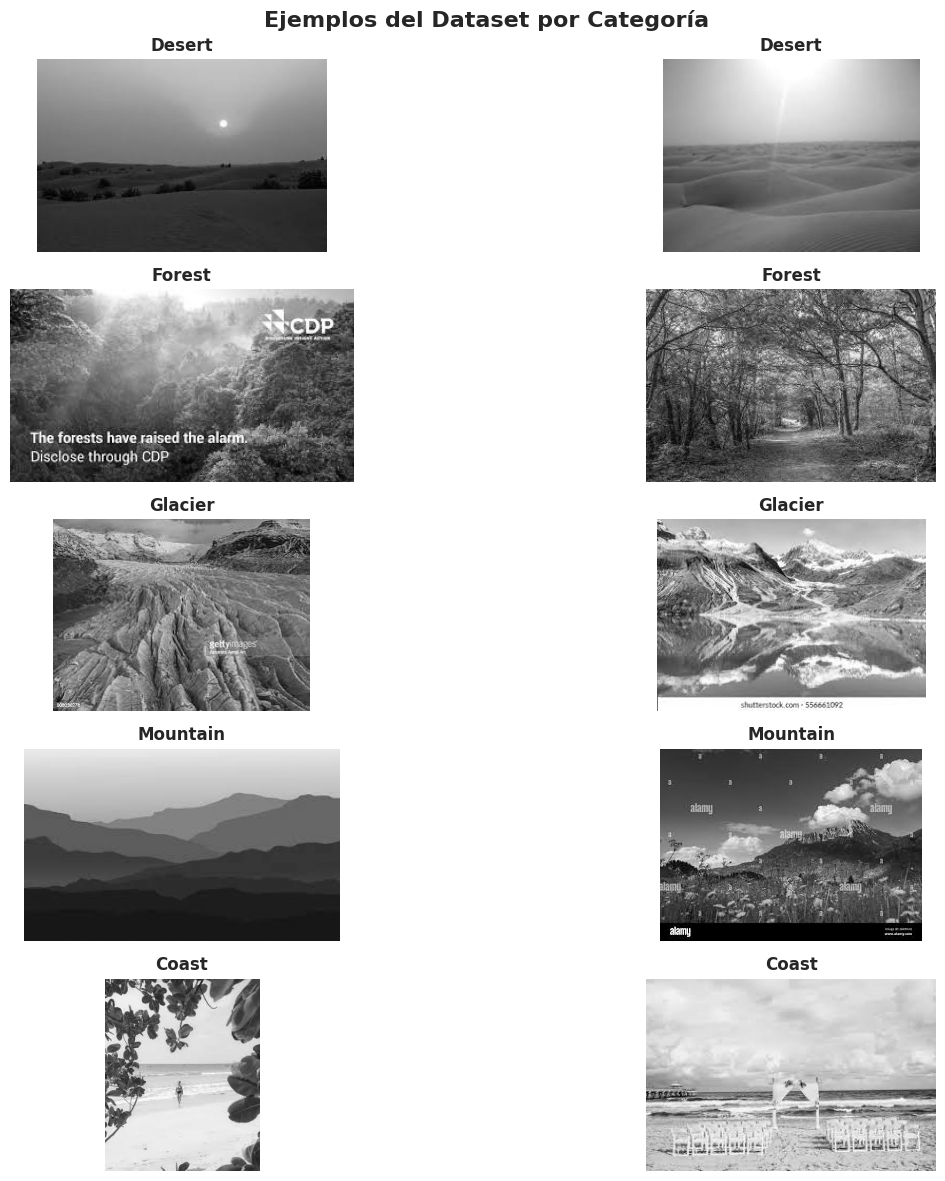

In [ ]:
mostrarEjemplosDataSet(imagenes_test, etiquetas_test, CATEGORIAS)

### ***2. Extracción de Características SIFT***
Con las imagenes cargadas, empezaremos por extraer cada uno de sus keypoints y descriptores de SIFT correspondientes. Luego utilizaremos estos datos para crear nuestras palabras visuales.

In [ ]:
def extraerSIFTImagen(imagen):
  """
  Extrae características SIFT de una imagen

  Returns:
    keypoints: coordenadas de los puntos clave
    descriptores: descriptores SIFT (128 dimensiones cada uno)
  """
  sift = SIFT()
  sift.detect_and_extract(imagen)

  return sift.keypoints, sift.descriptors

In [ ]:
def extraerSIFTDataSet(imagenes, etiquetas):
  """
  Extrae SIFT de todo el dataset

  Returns:
    keypoints_dataset: lista de keypoints por imagen
    descriptores_dataset: lista de descriptores por imagen
    estadisticas: diccionario con estadísticas de extracción
  """

  keypoints_dataset = []
  descriptores_dataset = []

  # Estadísticas por categoría
  stats = {cat: {'total_keypoints': 0, 'num_images': 0} for cat in CATEGORIAS}

  print("Extrayendo características SIFT...")

  # i: indice | img: imagen correspondiente | etiqueta: etiqueta correspondiente
  for i, (img, etiqueta) in enumerate(tqdm(zip(imagenes, etiquetas), total=len(imagenes))):

    keypoints, descriptores = extraerSIFTImagen(img)

    keypoints_dataset.append(keypoints)
    descriptores_dataset.append(descriptores)

    # Actualizar estadísticas
    stats[etiqueta]['total_keypoints'] += len(keypoints)
    stats[etiqueta]['num_images'] += 1

  # Calcular promedios
  for categoria in stats:
    if stats[categoria]['num_images'] > 0:
      stats[categoria]['promedio_keypoints'] = stats[categoria]['total_keypoints'] / stats[categoria]['num_images']

  return keypoints_dataset, descriptores_dataset, stats

In [ ]:
# Extraer SIFT del dataset de entrenamiento
print("\n" + "=" * 50)
print("EXTRACCIÓN DE CARACTERÍSTICAS SIFT - TRAINING")
print("=" * 50)

keypoints_train, descriptores_train, stats_train = extraerSIFTDataSet(imagenes_train, etiquetas_train)

# Mostrar estadísticas
print("\n📊 ESTADÍSTICAS DE EXTRACCIÓN SIFT:")
for categoria in CATEGORIAS:
    total = stats_train[categoria]['total_keypoints']
    promedio = stats_train[categoria]['promedio_keypoints']
    print(f"{categoria}: {total} keypoints total, {promedio:.1f} promedio por imagen")



EXTRACCIÓN DE CARACTERÍSTICAS SIFT - TRAINING
Extrayendo características SIFT...


  0%|          | 0/2913 [00:00<?, ?it/s]


📊 ESTADÍSTICAS DE EXTRACCIÓN SIFT:
Desert: 123189 keypoints total, 192.8 promedio por imagen
Forest: 411384 keypoints total, 631.9 promedio por imagen
Glacier: 223074 keypoints total, 446.1 promedio por imagen
Mountain: 188035 keypoints total, 376.1 promedio por imagen
Coast: 228616 keypoints total, 367.0 promedio por imagen


***VISUALIZACION***


VISUALIZACIÓN DE KEYPOINTS


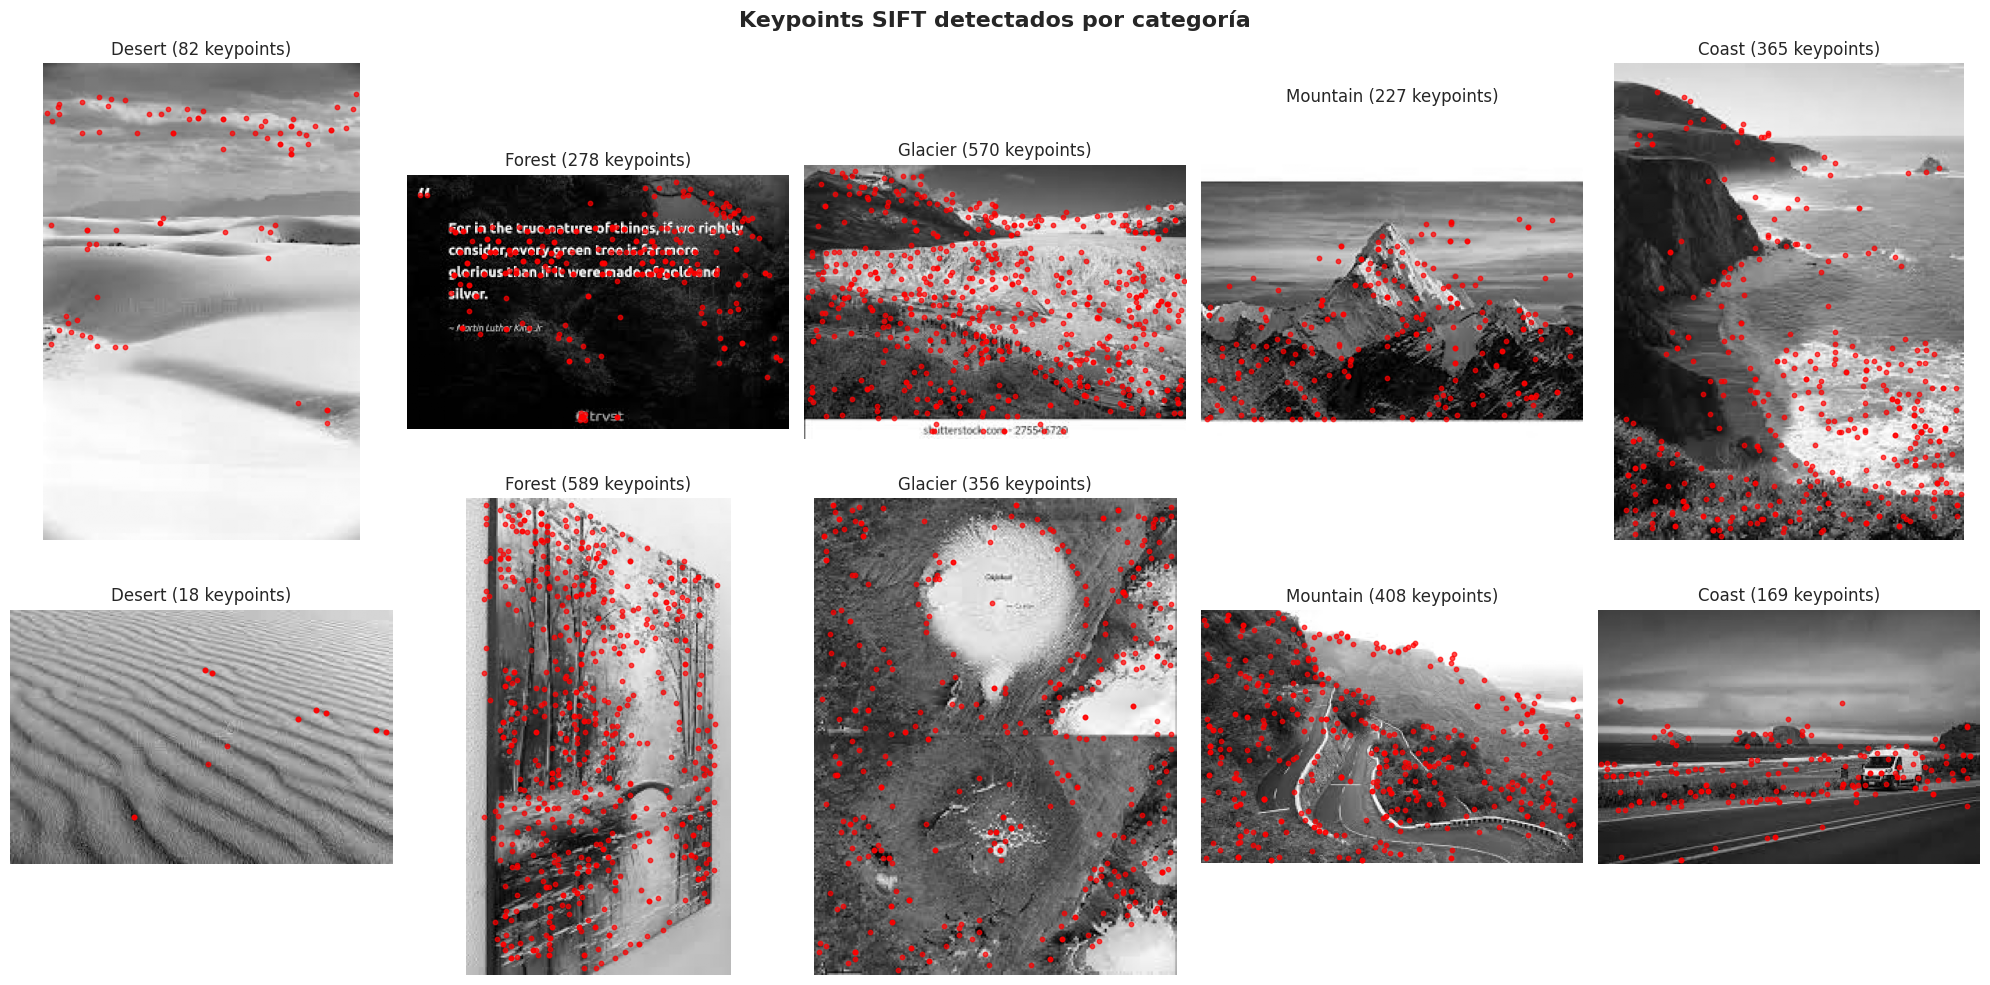

In [ ]:
# Visualizar keypoints en ejemplos
def mostrar_keypoints_ejemplos(imagenes, keypoints, etiquetas, categorias):
  """Muestra keypoints detectados en ejemplos de cada categoría"""

  fig, axes = plt.subplots(2, len(categorias), figsize=(20, 10))
  fig.suptitle('Keypoints SIFT detectados por categoría', fontsize=16, fontweight='bold')

  for i, categoria in enumerate(categorias):
    indices_categoria = indicesDeCategoriaEnLista(etiquetas, categoria)
    random.shuffle(indices_categoria)

    for row in range(2):
      img = indexadoIndirecto(row, indices_categoria, imagenes)
      kp = indexadoIndirecto(row, indices_categoria, keypoints)

      # Imagen original
      axes[row, i].imshow(img, cmap='gray')

      # Keypoints
      axes[row, i].scatter(kp[:, 1], kp[:, 0], s=10, c='red', alpha=0.7)

      axes[row, i].set_title(f'{categoria} ({len(kp)} keypoints)')
      axes[row, i].axis('off')

  plt.tight_layout()
  plt.show()

print("\n" + "=" * 50)
print("VISUALIZACIÓN DE KEYPOINTS")
print("=" * 50)
mostrar_keypoints_ejemplos(imagenes_train, keypoints_train, etiquetas_train, CATEGORIAS)

### ***3. Cross Validation***

Para poder encontrar los mejores parametros a usar en el categorizador sin caer en la trampa de **sobreajustarse a los datos de test**, utilizaremos la tecnica de **Cross Validation**.

Dividiremos nuestro set de entrenamiento en 5 subsets balanceados en categoria y aleatorios. Por cada uno de los subsets, tomaremos el resto de los 4 para **entrenar un categorizador** utilizando los meta-parametros a testear (numero de clusters, batch size, etc) y los testearemos sobre el subset apartado.

Por ultimo, utilizaremos la combinacion de meta-parametros que mejor accuracy hayan conseguido en **promedio**.

Con esta tecnica aumentamos las chances de generalizar sin tener que aumentar los datos de entrenamiento, ya que estariamos eligiendo los parametros que mayor capacidad de generalizacion obtuvieron.

In [ ]:
def getPorcionDeSubset(lista, indices_cat, cat_subset_inicio, cat_subset_fin):
  """
    Devuelve una sublista del arreglo original siendo indexada indirectamente
    por un arreglo con los indices de una categoria en especifico
  """

  return [indexadoIndirecto(idx, indices_cat, lista) for idx in range(cat_subset_inicio, cat_subset_fin)]

def crearSubsets(imagenes, etiquetas, nombres, keypoints, descriptores, n_subsets=5):
  """Devuelve una lista con los subsets creados al dividir el dataset de entrenamiento original"""

  # Encontramos los indices que le pertenecen a cada categoria
  # Encontramos cuantos item de cada categoria deberia haber por subset
  indices_categorias = {cat: indicesDeCategoriaEnLista(etiquetas,cat) for cat in CATEGORIAS}
  categoria_por_subset = {cat: math.ceil(len(indices_categorias[cat]) / n_subsets) for cat in CATEGORIAS}

  # Reordenamos los indices de las categorias de forma aleatoria
  for cat in CATEGORIAS:
    random.shuffle(indices_categorias[cat])

  subsets = []

  for subset_index in range(n_subsets):
    subset = {
        'imagenes': [],
        'etiquetas': [],
        'nombres': [],
        'keypoints': [],
        'descriptores': [],
        'stats': {cat: {'num_images': 0} for cat in CATEGORIAS}
      }

    for cat in CATEGORIAS:

      cat_indices = indices_categorias[cat]
      cat_subset_inicio = subset_index * categoria_por_subset[cat]
      cat_subset_fin = min(cat_subset_inicio + categoria_por_subset[cat], len(indices_categorias[cat]))

      cat_etiquetas = getPorcionDeSubset(etiquetas, cat_indices, cat_subset_inicio, cat_subset_fin)
      cat_descriptores = getPorcionDeSubset(descriptores, cat_indices, cat_subset_inicio, cat_subset_fin)
      cat_nombres = getPorcionDeSubset(nombres, cat_indices, cat_subset_inicio, cat_subset_fin)
      cat_imagenes = getPorcionDeSubset(imagenes, cat_indices, cat_subset_inicio, cat_subset_fin)
      cat_keypoints = getPorcionDeSubset(keypoints, cat_indices, cat_subset_inicio, cat_subset_fin)

      subset['etiquetas'] += (cat_etiquetas)
      subset['nombres'] += (cat_nombres)
      subset['descriptores']+=(cat_descriptores)
      subset['imagenes']+=(cat_imagenes)
      subset['keypoints']+=(cat_keypoints)

      subset['stats'][cat]['num_images'] = len(cat_imagenes)

    subsets.append(subset)

  return subsets

In [ ]:
subsets = crearSubsets(imagenes_train, etiquetas_train, nombres_train, keypoints_train, descriptores_train)

for i in range(len(subsets)):
    subset = subsets[i]

    print(f"Subset {i}")
    print(f"Imagenes Totales: {len(subset['etiquetas'])}")

    for categoria in CATEGORIAS:
      print(f"\t{categoria}: {subset['stats'][categoria]['num_images']} imagenes")

    print("\n")

Subset 0
Imagenes Totales: 584
	Desert: 128 imagenes
	Forest: 131 imagenes
	Glacier: 100 imagenes
	Mountain: 100 imagenes
	Coast: 125 imagenes


Subset 1
Imagenes Totales: 584
	Desert: 128 imagenes
	Forest: 131 imagenes
	Glacier: 100 imagenes
	Mountain: 100 imagenes
	Coast: 125 imagenes


Subset 2
Imagenes Totales: 584
	Desert: 128 imagenes
	Forest: 131 imagenes
	Glacier: 100 imagenes
	Mountain: 100 imagenes
	Coast: 125 imagenes


Subset 3
Imagenes Totales: 584
	Desert: 128 imagenes
	Forest: 131 imagenes
	Glacier: 100 imagenes
	Mountain: 100 imagenes
	Coast: 125 imagenes


Subset 4
Imagenes Totales: 577
	Desert: 127 imagenes
	Forest: 127 imagenes
	Glacier: 100 imagenes
	Mountain: 100 imagenes
	Coast: 123 imagenes




In [ ]:
def imagenesDeEjemploSubSet(subset, n_ejemplos=4):
  """Muestra ejemplos de cada categoría del subset"""

  fig, axes = plt.subplots(len(CATEGORIAS), n_ejemplos, figsize=(15, 12))
  fig.suptitle('Ejemplos del Sub Dataset por Categoría', fontsize=16, fontweight='bold')

  for i, categoria in enumerate(CATEGORIAS):
    # Encontrar índices de esta categoría
    indices_categoria = indicesDeCategoriaEnLista(subset['etiquetas'], categoria)
    random.shuffle(indices_categoria)

    # Mostramos imagenes de Ejemplos por categoria
    for j in range(n_ejemplos):

        img = indexadoIndirecto(j, indices_categoria, subset['imagenes'])
        axes[i, j].imshow(img, cmap='gray', clim=(0,1))
        axes[i, j].set_title(f'{categoria}', fontweight='bold')
        axes[i, j].axis('off')

  plt.tight_layout()
  plt.show()

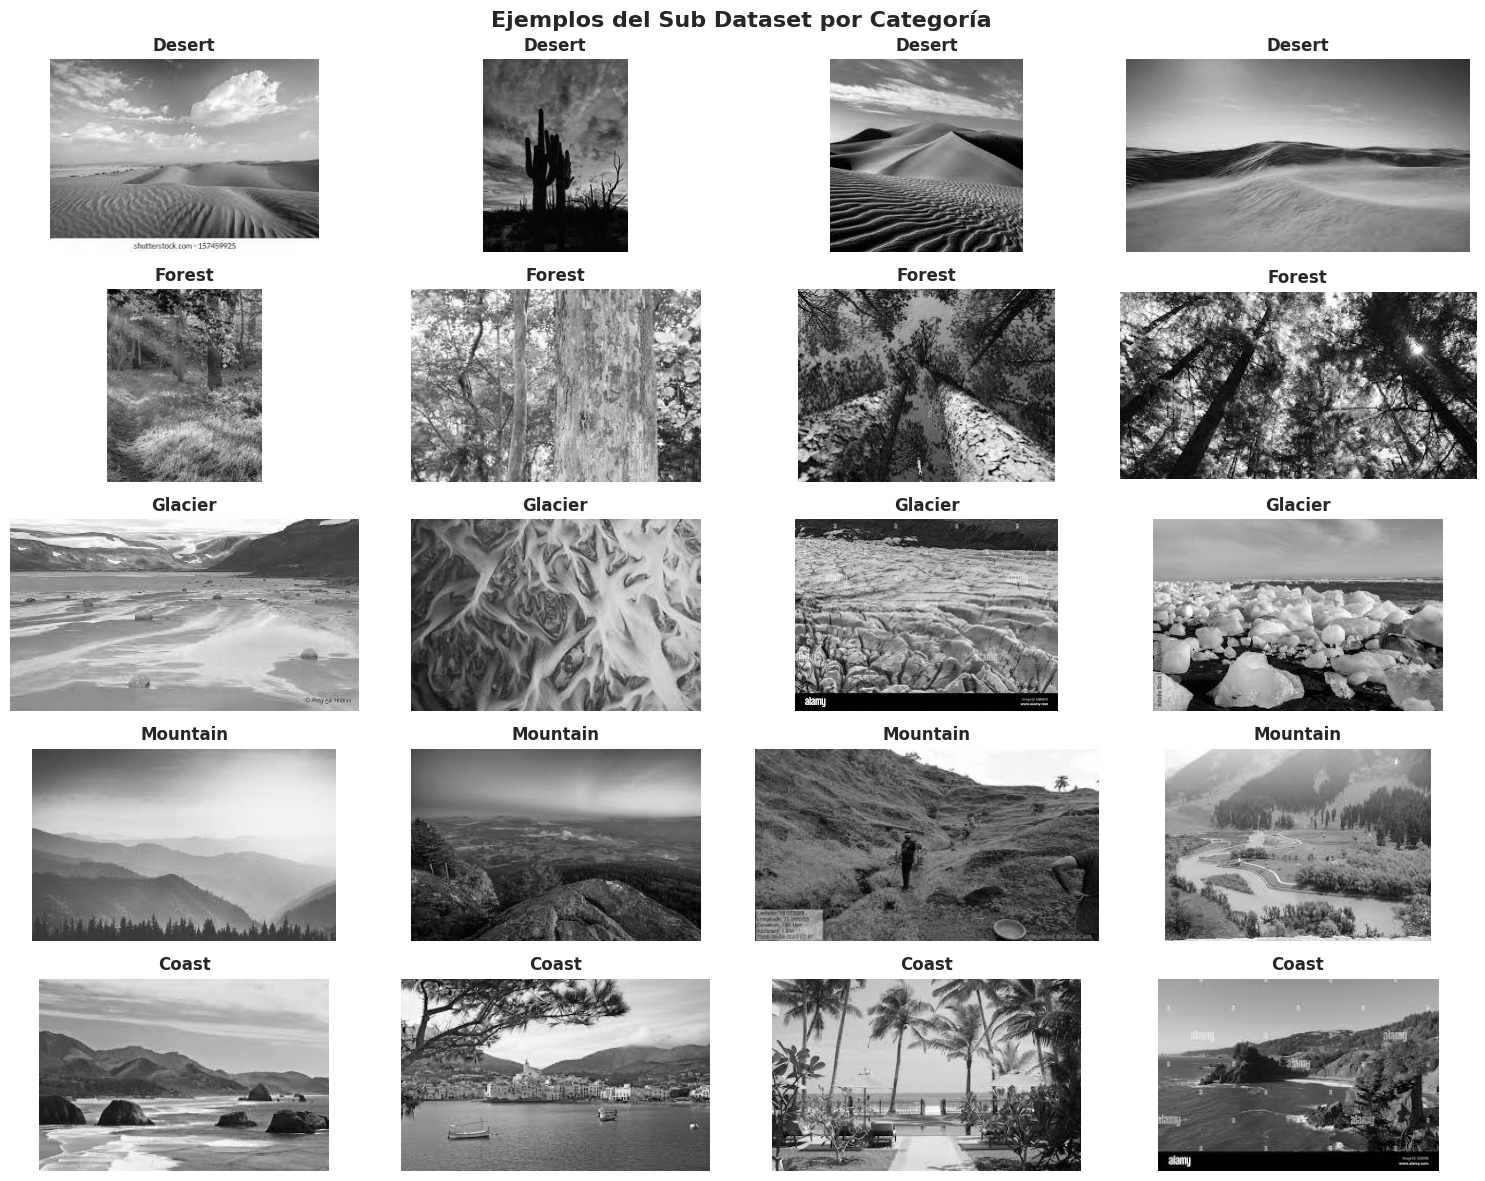

In [ ]:
imagenesDeEjemploSubSet(subsets[0])

In [ ]:
def unirSubsets(subsets):
  """Devuelve un subset conformado por la union de los subset en la lista"""

  subset_union = {
        'imagenes': [],
        'etiquetas': [],
        'nombres': [],
        'keypoints': [],
        'descriptores': [],
        'stats': {cat: {'num_images': 0} for cat in CATEGORIAS}
      }

  for subset in subsets:

    subset_union['etiquetas'] += subset['etiquetas']
    subset_union['nombres']+= subset['nombres']
    subset_union['descriptores']+= subset['descriptores']
    subset_union['imagenes']+= subset['imagenes']
    subset_union['keypoints']+= subset['keypoints']

    for cat in CATEGORIAS:
      subset_union['stats'][cat]['num_images'] += len(subset['etiquetas'])

  return subset_union


Por fines demostrativos, por ahora usaremos un dataset de entrenamiento fijo creado por [`subset_0`, `subset_1`, `subset_2`, `subset_3`] y `subset_4` sera el conjunto de validacion. Para encontrar los mejores parametros tendran que realizar el mismo procedimiento con cada uno de los subsets.

In [ ]:
training_subset = unirSubsets([subsets[0], subsets[1], subsets[2], subsets[3]])
validation_subset = subsets[4]

print(f"Training Subset")
print(f"Imagenes Totales: {len(training_subset['etiquetas'])}")

for categoria in CATEGORIAS:
  print(f"\t{categoria}: {training_subset['stats'][categoria]['num_images']} imagenes")

print("\n")

Training Subset
Imagenes Totales: 2336
	Desert: 2336 imagenes
	Forest: 2336 imagenes
	Glacier: 2336 imagenes
	Mountain: 2336 imagenes
	Coast: 2336 imagenes




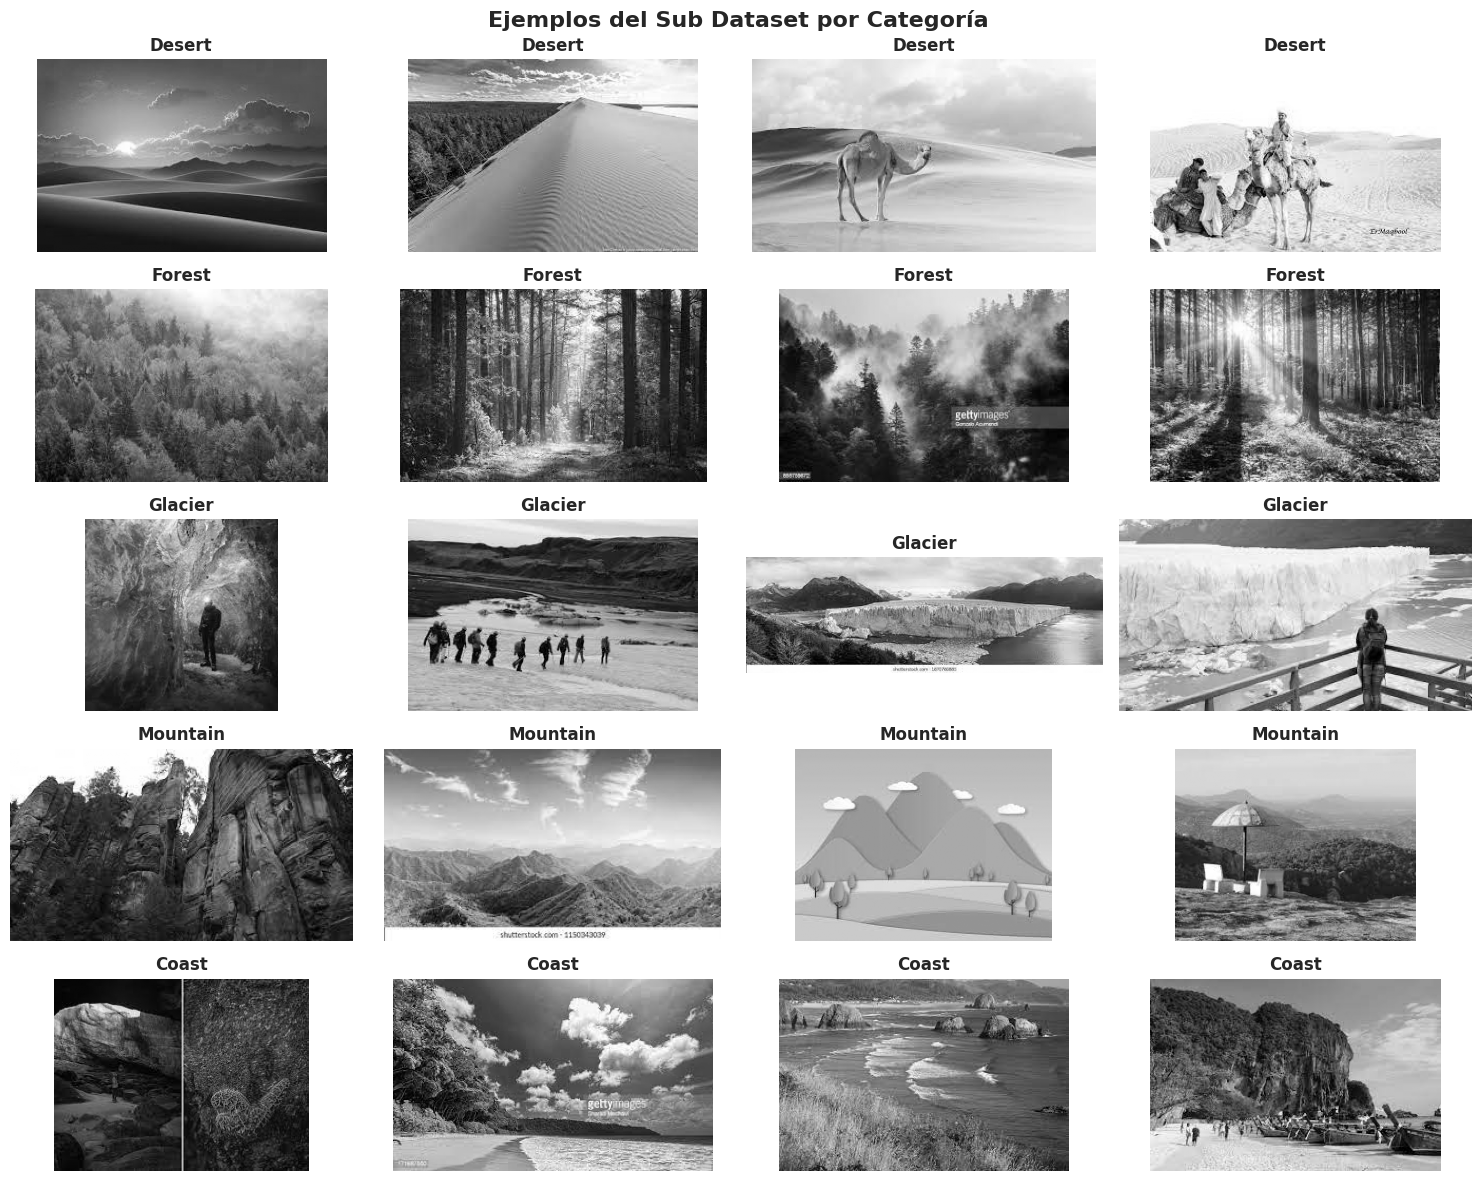

In [ ]:
imagenesDeEjemploSubSet(training_subset)

### ***PIPELINE de Entrenamiento***

Usaremos un `k` y `batch_size` fijo para ejemplificar, pero ustedes deberan parametrizar el pipeline de entrenamiento para poder encontrar los mejores paramentros utilizando **croos-validation**

---

*Construccion de Vocabulario Visual* ➡️ *Representacion BOW* ➡️ *Procesamiento de la Representacion* ➡️ *Entrenamiento de Categorizador* ➡️ *Validacion*

### ***4. Creación del Vocabulario Visual***

Ya teniendo los descriptores, podemos clasificarlos para comprender que keypoints eran similares a traves de las imagenes y empezar a hablar sobre el contenido de ellas.

Para esto utilizaremos un categorizador llamado MiniBatchKMeans, el cual hace lo mismo que K-means, pero en vez de tomar en cuenta todos los puntos, solo toma una cantidad fija de puntos aleatorios. El algoritmo eligira puntos de forma aleatoria iterativamente y devolvera los clusters encontrados que cuasaron la minima cantidad de varianza intra-cluster (menor distancia con el centroide).

Para mas informacion pueden leer la documentacion [oficial](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) y su [comparacion con kmeans](https://scikit-learn.org/stable/modules/clustering.html#mini-batch-kmeans)

---

***Construccion de Vocabulario Visual*** ➡️ *Representacion BOW* ➡️ *Procesamiento de la Representacion* ➡️ *Entrenamiento de Categorizador* ➡️ *Validacion*

In [ ]:
# Crear matriz global de descriptores para clustering
def crearMatrizDescriptores(descriptores_dataset):
    """
    Combina todos los descriptores en una matriz global para K-means
    Donde cada fila es un descriptor
    """
    matriz_descriptores = []

    for img_descriptors in descriptores_dataset:
      for descriptor in img_descriptors:
        matriz_descriptores.append(descriptor)

    return np.array(matriz_descriptores, dtype=np.float64)

In [ ]:
def construirVocabulario(descriptores, k=200, batch_size=1024, random_state=42):
  """
  Construye vocabulario visual usando K-means

  Args:
    descriptores: matriz de descriptores
    k: número de clusters (palabras visuales)
    batch_size: Cantidad de keypoints aleatorios que utilizara para encontrar los clusters (chico para hacer pruebas, luego incrementar)
    random_state: semilla para reproducibilidad

  Returns:
    kmeans: Categorizador K-Means entrenado para categorizar los descriptores a su centroido mas cercano
  """
  print(f"Construyendo vocabulario con k={k} palabras visuales...")

  kmeans = MiniBatchKMeans(
      n_clusters=k,
      random_state=random_state,
      batch_size=batch_size,
      max_iter=300,
      n_init=5,
      verbose=0
      )

  kmeans.fit(descriptores)

  return kmeans

In [ ]:
print("\n" + "=" * 50)
print("CONSTRUCCIÓN DEL VOCABULARIO VISUAL")
print("=" * 50)

K = 200
matriz_descriptores = crearMatrizDescriptores(training_subset['descriptores'])

print(f"\n--- Probando k = {K} ---")


# Creamos el vocabulario y tomamos su tiempo de creacion
inicio = time.time()
vocabulario = construirVocabulario(matriz_descriptores, K)
fin = time.time()
tiempo = fin - inicio

print(f"✅ Vocabulario creado en {tiempo:.1f} segundos")
print(f"    Varianza intra-cluster: {vocabulario.inertia_:.4f}") # Cuanto mas chico, mas concentrados seran los clusters


CONSTRUCCIÓN DEL VOCABULARIO VISUAL

--- Probando k = 200 ---
Construyendo vocabulario con k=200 palabras visuales...
✅ Vocabulario creado en 18.7 segundos
    Varianza intra-cluster: 71137984442.9786


### ***5. Representación Bag of Words***
Ya teniendo nuestro corpus o palabras visuales, podremos empezar a re-describir nuestras imagenes segun este. Gracias a esto podemos "hablar" de todas nuestras imagenes en el mismo "lenguaje", el nuevo descriptor.

Para la descripcion de una imagen utilizaremos la frecuencia de cada palabra en el vocabulario.

---

*Construccion de Vocabulario Visual* ➡️ ***Representacion BOW*** ➡️ *Procesamiento de la Representacion* ➡️ *Entrenamiento de Categorizador* ➡️ *Validacion*

In [ ]:
def descriptoresABOW(descriptores_imagen, vocabulario):
    """
    Convierte descriptores de una imagen a representación BoW

    Args:
        descriptores_imagen: np.array de descriptores SIFT de una imagen
        vocabulario: objeto MiniBatchKMeans entrenado (modelo del vocabulario visual)

    Returns:
        histograma: vector de frecuencias de palabras visuales (BoW)
    """
    n_clusters = vocabulario.n_clusters

    # Asignar cada descriptor al centroide más cercano (palabra visual)
    asignaciones = vocabulario.predict(descriptores_imagen)

    # Construir histograma de frecuencias de palabras visuales
    histograma, _ = np.histogram(asignaciones, bins=n_clusters, range=(0,n_clusters), density=None, weights=None)

    return histograma.astype(float)

In [ ]:
def crearMatrizBOW(descriptores_dataset, vocabulario):
    """
    Crea matriz BoW para todo el dataset
    Donde Cada fila es la frecuencia del vocabulario en una imagen
    """
    matriz_bow = []

    print("Creando representaciones BoW...")

    for img_descriptors in descriptores_dataset:
      frecuencia = descriptoresABOW(img_descriptors, vocabulario)
      matriz_bow.append(frecuencia)

    return np.array(matriz_bow)

In [ ]:
print("\n" + "=" * 50)
print("CONSTRUCCIÓN DE REPRESENTACIONES BAG OF WORDS")
print("=" * 50)

print(f"\n--- Creando BoW con k={K} ---")
representaciones_bow = crearMatrizBOW(training_subset['descriptores'], vocabulario)
print(f"✅ Matriz BoW shape: {representaciones_bow.shape}")



CONSTRUCCIÓN DE REPRESENTACIONES BAG OF WORDS

--- Creando BoW con k=200 ---
Creando representaciones BoW...
✅ Matriz BoW shape: (2336, 200)


### ***6. TF-IDF***
Con la Matriz de Representacion de Bag Of Words creada, podemos empezar a transformarla para intentar conseguir un mejor puntaje de forma barata. Una de nuestras opciones es aplicarle **TF-IDF**, presentado en la clase practica, con la intencion de darle mas importancia a las palabras visuales menos frecuentes y bajar el impacto de palabras comunes que no aportan informacion. Si pensamos en una analogia con texto, seria el equivalente de "bajarle el precio" a conectores, pronombres, articulos y etc.

$$
\text{Tf-idf}_{t,d} = \text{tf}_{t,d} ⋅ log(\frac{N}{\text{df}_t})
$$

donde
- $\text{Tf-idf}_{t,d}$ sera el nuevo valor de la palabra $t$ para la imagen $d$
- $\text{tf}_{t,d}$ era la frecuencia de la palabra $t$ para la imagen $d$
- $N$ es la cantidad de imagenes totales
- $\text{df}_t$ es la cantidad de imagenes en la que la palabra $t$ aparece al menos una vez.

---

*Construccion de Vocabulario Visual* ➡️ *Representacion BOW* ➡️ ***Procesamiento de la Representacion*** ➡️ *Entrenamiento de Categorizador* ➡️ *Validacion*

In [ ]:
def aplicar_tfidf(matriz_bow):
  """
  Aplica transformación TF-IDF a matriz de frecuencias

  Args:
    matriz_bow: matriz de frecuencias (n_images x n_words)

  Returns:
    matriz_tfidf: matriz con pesos TF-IDF
  """

  # las filas son las imagenes y las columnas es la frecuencia con la que aparece una determinada palabra visual en cada una de las imagenes
  n = matriz_bow.shape[0]
  m = matriz_bow.shape[1]

  # primero contamos la cantidad de aparicinos de una palabra visual en el conjunto de imagenes
  df = np.zeros(m)
  for i in range(n):
    for j in range(m):
      if matriz_bow[i][j] > 0:
        df[j] += 1

  # construimos la nueva matriz de frecuencias
  matriz_tfidf = np.zeros((n, m))
  for i in range(n):
    for j in range(m):
      if df[j] > 0:
        matriz_tfidf[i][j] = matriz_bow[i][j] * np.log(n / df[j])


  return matriz_tfidf

In [ ]:
print("\n" + "=" * 50)
print("TF-IDF")
print("=" * 50)

# Aplicamos TF-IDF
print(f"\n--- Aplicando TF-IDF con k={K} ---")

representaciones_tfidf = aplicar_tfidf(representaciones_bow)

# Comparar estadísticas antes y después
bow_mean = np.mean(representaciones_bow)
tfidf_mean = np.mean(representaciones_tfidf)

print(f"Frecuencias simples - Media: {bow_mean:.4f}")
print(f"TF-IDF - Media: {tfidf_mean:.4f}")


TF-IDF

--- Aplicando TF-IDF con k=200 ---
Frecuencias simples - Media: 2.0180
TF-IDF - Media: 0.7995


### ***7. Entrenamiento de un Clasificador***

Ya habiendo aplicado todo el **post-procesamiento** que quisieramos a nuestra aplicacion, solo nos queda usarla para entrenar un **Categorizador de Escenas** que luego utilizaremos para hacer predicciones con imagenes entrantes nuevas.

En este caso usaremos una **SVC** por su flexibilidad y por ya haber sido presentada en la Tarea anterior. Recordemos que una **SVC** encuentra los mejores Hiper Planos para separar los puntos de cada categoria, dejandonos aplicarle una **transformacion a los datos de entradas a un espacio de dimensionalidad mayor** si nos es necesario para encontrar hiperplanos validos.

---

*Construccion de Vocabulario Visual* ➡️ *Representacion BOW* ➡️ *Procesamiento de la Representacion* ➡️ ***Entrenamiento de Categorizador*** ➡️ *Validacion*

In [ ]:
def entrenar_svm(descriptores_train, etiquetas_train):
    """
    Entrena un clasificador SVM

    Returns:
        clf: pipeline con SVC
    """

    # make_pipeline les permite crear un pipeline sobre el propio categorizador SVC
    # por si quieren hacer un procesamiento mas general de los datos antes de enviarlos a la SVC
    clf = make_pipeline(SVC(kernel='linear', probability=True))
    clf.fit(descriptores_train, etiquetas_train)
    return clf

In [ ]:
print(f"\n{'='*50}")
print(f"ENTRENANDO CLASIFICADOR CON K={K}")
print(f"{'='*50}")

# Clasificadores SVM
# Por cada procesamiento que hagan sobre la representacion, deberan crear un nuevo categorizador
# entrenado sobre ellos.

clasificador_bow = entrenar_svm(representaciones_bow, training_subset['etiquetas'])

print(f"\n✅ Clasificador BoW Entrenado")

clasificador_tfidf = entrenar_svm(representaciones_tfidf, training_subset['etiquetas'])

print(f"\n✅ Clasificador TFIDF Entrenado")



ENTRENANDO CLASIFICADOR CON K=200

✅ Clasificador BoW Entrenado

✅ Clasificador TFIDF Entrenado


### ***8. Validacion***

Con nuestro Clasificador entrenado, solo queda probarlo con los datos de validacion. Para esto tendremos que representar nuestras imagenes de validacion utilizando el vocabulario y las transformaciones de post-procesamiento con las que se entreno la SVM.

Luego podremos analizar con mas detalles que puntos debiles tiene nuestro clasificador, por ejemplo, cuales son las categorias que mas se confunde entre si.

---

*Construccion de Vocabulario Visual* ➡️ *Representacion BOW* ➡️ *Procesamiento de la Representacion* ➡️ *Entrenamiento de Categorizador* ➡️ ***Validacion***

In [ ]:
def evaluar_clasificador_svm(clasificador, descriptores_bow_test, etiquetas_test, nombre_experimento=""):
  """
  Evalúa el clasificador SVM
  Args:
    clasificador: Clasificador a Evaluar
    descriptores_bow_test: Descriptores de BoW a categorizar
    etiquetas_test: Ground Truth para cada descriptor
    nombre_experimento: Nombre opcional a imprimr

  Returns:
    predicciones: Etiquetas predichas por el clasificador para cada muestra del conjunto de prueba.
    confianzas: Probabilidad más alta asignada por el modelo a la clase predicha para cada muestra (valor entre 0 y 1).
    accuracy: Proporción de etiquetas correctamente clasificadas sobre el total de muestras: (n° aciertos) / (n° total).
    precision: Para cada categoría, proporción de verdaderos positivos entre todos los predichos como esa categoría: TP / (TP + FP).
    recall: Para cada categoría, proporción de verdaderos positivos entre los casos reales de esa categoría: TP / (TP + FN).
    f1: Para cada categoría, media armónica entre precisión y recall: 2 * (precision * recall) / (precision + recall).
    support: Número real de muestras en cada categoría dentro del conjunto de prueba (distribución real por clase).
    confusion_matrix: Matriz de Confusion
  """

  print(f"Evaluando clasificador: {nombre_experimento}")

  # Predicción
  predicciones = clasificador.predict(descriptores_bow_test)

  # Confianzas: tomamos la probabilidad de la clase predicha
  confianzas_prob = clasificador.predict_proba(descriptores_bow_test)
  confianzas = confianzas_prob.max(axis=1)

  # Métricas
  accuracy = accuracy_score(etiquetas_test, predicciones)

  precision, recall, f1, support = precision_recall_fscore_support(
      etiquetas_test, predicciones, average=None, labels=CATEGORIAS
  )

  # Creamos una Matriz de Confusion para ver en que categorias se confunde nuestro clasificador
  cm = confusion_matrix(etiquetas_test, predicciones, labels=CATEGORIAS)

  return {
    'predicciones': predicciones,
    'confianzas': confianzas,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'support': support,
    'confusion_matrix': cm
  }

In [ ]:
print(f"\n{'='*50}")
print(f"VALIDACION CON K={K}")
print(f"{'='*50}")
print()

# Creamos las Representaciones de BoW con el vocabulario obtenido para los datos de validacion
bow_validacion = crearMatrizBOW(validation_subset['descriptores'], vocabulario)
tfidf_validacion = aplicar_tfidf(bow_validacion)

etiquetas_validacion = validation_subset['etiquetas']

# Validamos cada Categorizador
resultado_bow = evaluar_clasificador_svm(clasificador_bow, bow_validacion, etiquetas_validacion, f"SVM-BoW (k={K})")
resultado_tfidf = evaluar_clasificador_svm(clasificador_tfidf, tfidf_validacion, etiquetas_validacion, f"SVM-TF-IDF (k={K})")

resultados_experimentos = {
  'bow': resultado_bow,
  'tfidf': resultado_tfidf
}

# Deberia darle Aprox un 0.5
print(f"\nRESULTADOS k={K}:")
print(f"\tBoW Accuracy: {resultado_bow['accuracy']:.3f}")
print(f"\tTF-IDF Accuracy: {resultado_tfidf['accuracy']:.3f}")



VALIDACION CON K=200

Creando representaciones BoW...
Evaluando clasificador: SVM-BoW (k=200)
Evaluando clasificador: SVM-TF-IDF (k=200)

RESULTADOS k=200:
	BoW Accuracy: 0.503
	TF-IDF Accuracy: 0.490


### ***8 Bis. Analisis de Resultados***
Ya teniendo una muestra de como funciona nuestro categorizador, analizemos en mas detalle su desempeño.

#### **Funciones de Analisis**

In [ ]:
def crearTablaResultados(resultados, k, metodos):
  """Crea tabla resumen con todos los resultados"""

  print("\n📊 TABLA RESUMEN DE RESULTADOS")
  print("=" * 90)
  print(f"{'Config':<35} {'Accuracy':<10} {'Precisión':<12} {'Recall':<10} {'F1-Score':<10}")

  for (metodo, titulo) in metodos:
    res = resultados[metodo]
    config = f"{titulo} (k={k})"
    acc = res['accuracy']
    prec = np.mean(res['precision'])
    rec = np.mean(res['recall'])
    f1 = np.mean(res['f1'])

    print(f"{config:<35} {acc:<10.3f} {prec:<12.3f} {rec:<10.3f} {f1:<10.3f}")

  print("-" * 90)
  print()

In [ ]:
def plotConfusionMatrices(resultados, k_valor, metodos):
    """Plotea matrices de confusión para un valor de k específico"""

    fig, axes = plt.subplots(1, len(metodos), figsize=(15, 6))

    for i, (metodo, titulo) in enumerate(metodos):

        cm = resultados[metodo]['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=[cat for cat in CATEGORIAS],
                   yticklabels=[cat for cat in CATEGORIAS],
                   ax=axes[i])

        axes[i].set_title(f'{titulo} (k={k_valor})')
        axes[i].set_xlabel('Predicción')
        axes[i].set_ylabel('Verdadero')

    plt.tight_layout()
    plt.show()

In [ ]:
def analizar_errores(resultados, metodo, testing_set):
  """Devuelve los errores de clasificación"""

  resultado = resultados[metodo]
  predicciones = resultado['predicciones']

  etiquetas = testing_set['etiquetas']
  imagenes = testing_set['imagenes']
  nombres = testing_set['nombres']

  # Encontrar errores
  errores = []
  for i, (real, pred) in enumerate(zip(etiquetas, predicciones)):
    if real != pred:
      errores.append({
        'real': real,
        'predicho': pred,
        'imagen': imagenes[i],
        'imagen_nombre': nombres[i],
        'confianza': resultado['confianzas'][i]
      })

  return errores

In [ ]:
def imprimirErrores(errores, k, metodo, total):
  """Imprime informacion sobre los errores"""

  print(f"\n🔍 ANÁLISIS DE ERRORES ({metodo.upper()}, k={k})")
  print("-" * 50)
  print(f"Total de errores: {len(errores)} de {total} imágenes")
  print(f"Accuracy: {(total - len(errores))/total:.3f}")

  # Análisis de confusiones más comunes
  confusiones = {}
  for error in errores:
    par = (error['real'], error['predicho'])
    if par not in confusiones:
      confusiones[par] = []
    confusiones[par].append(error)

  print(f"\n📊 CONFUSIONES MÁS COMUNES:")
  for (real, pred), casos in sorted(confusiones.items(), key=lambda x: len(x[1]), reverse=True):
    print(f"  {real} → {pred}: {len(casos)} casos")

  print()

In [ ]:
# Mostrar ejemplos de errores
def mostrarEjemplosErrores(errores, n_ejemplos=4):
  """Muestra ejemplos visuales de errores de clasificación"""

  if len(errores) == 0:
    print("¡No hay errores para mostrar!")
    return

  n_mostrar = min(n_ejemplos, len(errores))
  errores_sample = random.sample(errores, k=n_mostrar)
  fig, axes = plt.subplots(n_mostrar, 1, figsize=(15, 10))

  fig.suptitle('Ejemplos de Errores de Clasificación', fontsize=16, fontweight='bold')

  for i in range(n_mostrar):
    error = errores_sample[i]

    axes[i].imshow(error['imagen'], cmap='gray', clim=(0,1))

    axes[i].set_title(f'Real: {error["real"].title()}\n'
                      f'Predicho: {error["predicho"].title()}\n'
                      f'Confianza: {error["confianza"]:.3f}')

    axes[i].axis('off')

  plt.tight_layout()
  plt.show()

#### **Analisis**


ANÁLISIS DE RESULTADOS 1/2

📊 TABLA RESUMEN DE RESULTADOS
Config                              Accuracy   Precisión    Recall     F1-Score  
Frecuencias Simples (k=200)         0.503      0.503        0.486      0.489     
TF-IDF (k=200)                      0.490      0.496        0.476      0.481     
------------------------------------------------------------------------------------------



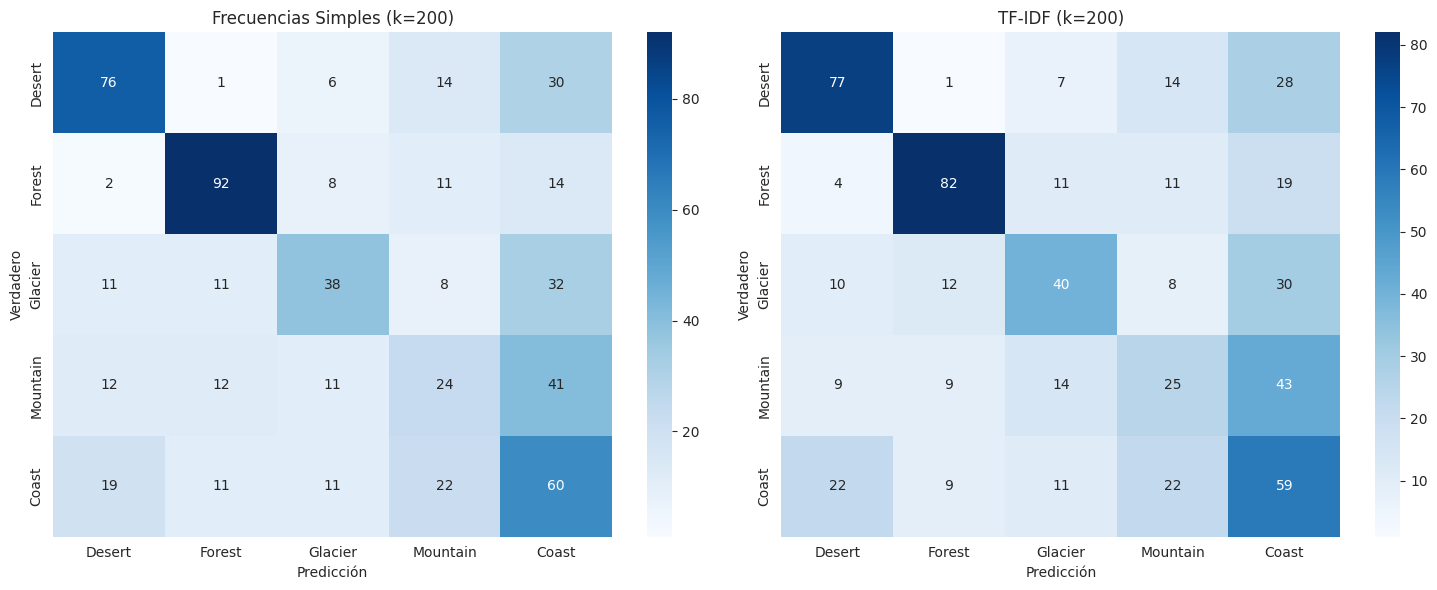

In [ ]:
print("\n" + "=" * 50)
print("ANÁLISIS DE RESULTADOS 1/2")
print("=" * 50)

# Tabla resumen de resultados
metodos = [('bow', 'Frecuencias Simples'), ('tfidf', 'TF-IDF')]

crearTablaResultados(resultados_experimentos, K, metodos)
plotConfusionMatrices(resultados_experimentos, K, metodos)

In [ ]:
print("\n" + "=" * 50)
print("ANÁLISIS DE RESULTADOS 2/2")
print("=" * 50)

# Encontramos los errores de nuestro categorizador
errores = analizar_errores(resultados_experimentos, 'bow', validation_subset)

# Imprimimos la informacion relevante
imprimirErrores(errores, K, 'bow', len(validation_subset['etiquetas']))


ANÁLISIS DE RESULTADOS 2/2

🔍 ANÁLISIS DE ERRORES (BOW, k=200)
--------------------------------------------------
Total de errores: 287 de 577 imágenes
Accuracy: 0.503

📊 CONFUSIONES MÁS COMUNES:
  Mountain → Coast: 41 casos
  Glacier → Coast: 32 casos
  Desert → Coast: 30 casos
  Coast → Mountain: 22 casos
  Coast → Desert: 19 casos
  Desert → Mountain: 14 casos
  Forest → Coast: 14 casos
  Mountain → Desert: 12 casos
  Mountain → Forest: 12 casos
  Forest → Mountain: 11 casos
  Glacier → Forest: 11 casos
  Glacier → Desert: 11 casos
  Mountain → Glacier: 11 casos
  Coast → Forest: 11 casos
  Coast → Glacier: 11 casos
  Forest → Glacier: 8 casos
  Glacier → Mountain: 8 casos
  Desert → Glacier: 6 casos
  Forest → Desert: 2 casos
  Desert → Forest: 1 casos



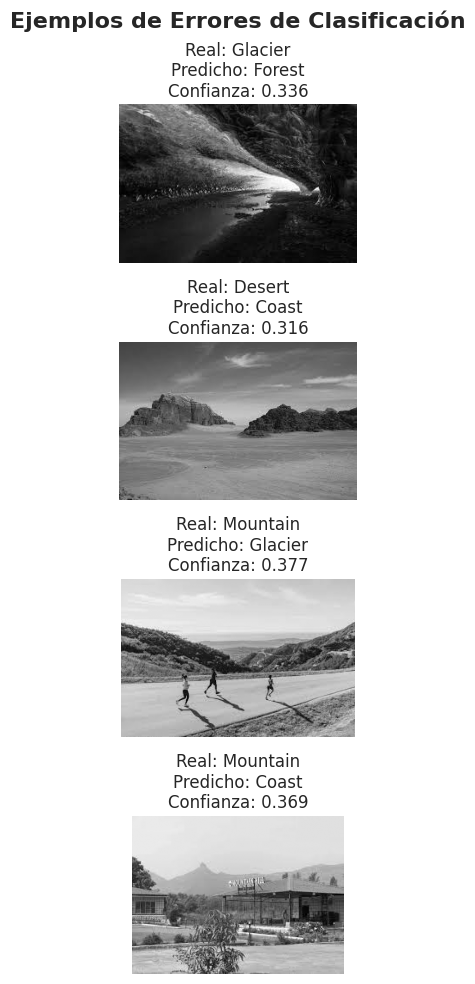

In [ ]:
# Mostramos algunos ejemplos de errores
mostrarEjemplosErrores(errores)

---
## **CONSIGNAS**




### 🧪 Parte 1: **Cross Validation**

Luego de completar el codigo faltante, realicen un experimento de cross validation probando combinaciones de los siguientes hiperparámetros:

  - Número de clusters para BoW (`k`):

    `100`, `200`, `400`, `800`

  - Tamaño de batch para entrenamiento del vocabulario (`batch_size`):

    `512`, `1024`, `2048`, `4096`, `8192`

Para cada combinación, registren:

  - **Precisión** (accuracy)

  - **Tiempo de entrenamiento**

Para completar esta parte, sera necesario que automaticen el pipeline visto en las celdas anteriores.

### 📊 Parte 2: **Análisis de Resultados**

Respondan las siguientes preguntas a partir de los resultados obtenidos:

1.   ¿Cómo afecta el valor de `k` al rendimiento del clasificador? Expliquen el impacto en precisión y en el costo computacional (tiempo y memoria).

2.   ¿Qué relación observan entre `batch_size` y el tiempo de cómputo o el rendimiento del modelo? ¿Existe un valor de `batch_size` que parezca óptimo?

3.   ¿Cuál consideran que es la mejor combinación de `k` y `batch_size`? Justifiquen y argumente el criterio utilizado: ¿priorizaron precisión, eficiencia, o un balance entre ambos?




### 🔄 Parte 3: Procesamiento (TF-IDF)

1. ¿Mejora el rendimiento al utilizar una representación con TF-IDF en lugar de frecuencias simples?

  - Comparen la precisión obtenida con la versión sin TF-IDF.


### 🤖 Parte 4: Resultados Finales y Conclusiones

Una vez analizados los hiperparámetros y modelos, seleccionen la mejor configuración del sistema:

- Valor óptimo de `k`
- Valor óptimo de `batch_size`
- Tipo de representación final: **BoW**, **BoW + TF-IDF**

Entrenen un modelo definitivo utilizando **todo el conjunto de entrenamiento** con estos parámetros y evalúelo sobre el **conjunto de test**.

---

### 📈 1. Métricas Finales

- Reporten las métricas obtenidas en el conjunto de test:
  - `accuracy`
  - `precision`
  - `recall`
  - `f1-score` (por clase)
- Incluya la **matriz de confusión** correspondiente.

---

### 🔍 2. Análisis de Errores

- ¿Qué categorías o ambientes se confunden más entre sí?
- ¿Por qué creen que ocurre esa confusión?
  - Ejemplos: similitud visual, baja representación de datos, condiciones de iluminación.

---

### 🧠 3. Ejemplos Específicos

Muestren al menos **2 o 3 ejemplos concretos** donde el sistema se equivoca:

- Etiqueta verdadera vs. predicción
- Comentario sobre el posible motivo del error

---

### 📊 4. Visualizaciones

Escriban visualizaciones que ayuden a interpretar el comportamiento del sistema:

- **Distribución de palabras visuales por categoría**
- **Keypoints más característicos** por clase

---

### ⚠️ 5. Limitaciones Observadas

Describan **2 o 3 limitaciones** del sistema:

- ¿En qué tipos de imágenes o ambientes tiende a fallar?
- ¿Qué factores afectan negativamente el rendimiento?

---

### 🚀 6. Propuestas de Mejora

Propongan al menos **2 o 3 ideas concretas** para mejorar el sistema. Por ejemplo:

- Inclusión de color o textura como información adicional
- Cambiar el clasificador (Random Forest, redes neuronales)
- Limpieza del dataset
- etc

---

## **Respuestas**



### ***Parte 1 -  Cross validation para encontrar  los mejore hiperparametros y analisis***

#### ***1) Cross Validation***

Función para automatizar el proceso de entrenamiento y evaluación



In [ ]:
def entrenar_y_evaluar_bow(k, batch_size, matriz_descriptores_entrenamiento, training_subset, validation_subset):
  """
  Obtiene
    k: Numero de clusters para el vocabulario
    batch_size: Tamaño de batch para K-means
    descriptores_entrenamiento: Lista de arrays con descriptores SIFT
    training_subset: Diccionario con datos de entrenamiento
    validation_subset: Diccionario con datos de validación
  """

  # medimos el tiempo que tarda en ejecutarse la funcion
  inicio = time.time()

  # 1) construir el vocabulario
  vocabulario = construirVocabulario(matriz_descriptores_entrenamiento, k, batch_size)

  # 2) representacion BOW
  representaciones_bow = crearMatrizBOW(training_subset['descriptores'], vocabulario)

  # 3) procesamiento de la representacion (TF-IDF)
  representaciones_tfidf = aplicar_tfidf(representaciones_bow)

  # 4) entrenamiento de Categorizador
  clasificador_bow = entrenar_svm(representaciones_bow, training_subset['etiquetas'])
  clasificador_tfidf = entrenar_svm(representaciones_tfidf, training_subset['etiquetas'])


  # 5) validacion

  # data validacion
  bow_validacion = crearMatrizBOW(validation_subset['descriptores'], vocabulario)
  tfidf_validacion = aplicar_tfidf(bow_validacion)

  etiquetas_validacion = validation_subset['etiquetas']

  # evaluamos resultados
  resultado_bow = evaluar_clasificador_svm(clasificador_bow, bow_validacion, etiquetas_validacion, f"SVM-BoW (k={k})")
  resultado_tfidf = evaluar_clasificador_svm(clasificador_tfidf, tfidf_validacion, etiquetas_validacion, f"SVM-TF-IDF (k={k})")


  # tiempo final
  fin = time.time()
  tiempo = fin - inicio


  return {
        "k": k,
        "batch_size": batch_size,
        "precision_bow": resultado_bow['accuracy'],
        "precision_tfidf": resultado_tfidf['accuracy'],
        "tiempo_entrenamiento": tiempo
    }

Iteramos por todas las combinaciones posibles de hiperametros + combinaciones (para no caer en overfitting)

In [ ]:
# Lista de hiperparametros
valores_k = [100, 200, 400, 800]
valores_batch_size = [512, 1024, 2048, 4096, 8192]

#subsets de entrenamiento + subset de validacion
combinaciones_entrenamiento_validacion = [ ([1, 2, 3, 4], 0),
    ([0, 2, 3, 4], 1),
    ([0, 1, 3, 4], 2),
    ([0, 1, 2, 4], 3),
    ([0, 1, 2, 3], 4)
]

#Resultados de cada cross_validations
resultados_cross_validation = []

for k in valores_k:
  for tamaño_batch in valores_batch_size:

    print(f"Estamos en el caso con {k} clusters y {tamaño_batch} tamaño de batch")

    precisiones_bow = []
    precisiones_tfidf = []
    tiempos = []

    #Nos Guardamos todos los tiempos y precisiones de ese k y batch_size para todas las combinaciones posibles
    for combinacion, (indices_subset_entrenamiento, indice_subset_validacion) in enumerate(combinaciones_entrenamiento_validacion):
      print(f"Estamos en la combinacion {combinacion}")

      #Unimos subsets para entrenamiento y separamos validacion
      subset_entrenamiento = unirSubsets([subsets[i] for i in indices_subset_entrenamiento])
      subset_validacion = subsets[indice_subset_validacion]

      #Evaluamos para ese subset particular
      resultado_combinacion = entrenar_y_evaluar_bow(k, tamaño_batch, crearMatrizDescriptores(training_subset['descriptores']), subset_entrenamiento, subset_validacion)

      #Nos guardamos resultado de esta combinacion
      precisiones_bow.append(resultado_combinacion['precision_bow'])
      precisiones_tfidf.append(resultado_combinacion['precision_tfidf'])
      tiempos.append(resultado_combinacion['tiempo_entrenamiento'])

    #Ahora que tenemos todos los resultados posibles para ese k y tamaño de batch, lo promediamos
    resultado_promedio = {
        "k": k,
        "batch_size": tamaño_batch,
        "precision_bow_mean": np.mean(precisiones_bow),
        "precision_tfidf_mean": np.mean(precisiones_tfidf),
        'time_mean': np.mean(tiempos)
    }

    resultados_cross_validation.append(resultado_promedio)




Estamos en el caso con 100 clusters y 512 tamaño de batch
Estamos en la combinacion 0
Construyendo vocabulario con k=100 palabras visuales...
Creando representaciones BoW...
Creando representaciones BoW...
Evaluando clasificador: SVM-BoW (k=100)
Evaluando clasificador: SVM-TF-IDF (k=100)
Estamos en la combinacion 1
Construyendo vocabulario con k=100 palabras visuales...
Creando representaciones BoW...
Creando representaciones BoW...
Evaluando clasificador: SVM-BoW (k=100)
Evaluando clasificador: SVM-TF-IDF (k=100)
Estamos en la combinacion 2
Construyendo vocabulario con k=100 palabras visuales...
Creando representaciones BoW...
Creando representaciones BoW...
Evaluando clasificador: SVM-BoW (k=100)
Evaluando clasificador: SVM-TF-IDF (k=100)
Estamos en la combinacion 3
Construyendo vocabulario con k=100 palabras visuales...
Creando representaciones BoW...
Creando representaciones BoW...
Evaluando clasificador: SVM-BoW (k=100)
Evaluando clasificador: SVM-TF-IDF (k=100)
Estamos en la comb

Mostamos el Dataframe Final para visualizar el promedio de precision y tiempo para cada combinación posible

In [ ]:
import pandas as pd

#Vemos el dataframe final
resultados_df = pd.DataFrame(resultados_cross_validation)
resultados_df

k  batch_size  precision_bow_mean  precision_tfidf_mean   time_mean
0   100         512            0.525219              0.530373  338.807109
1   100        1024            0.540626              0.544756  353.657739
2   100        2048            0.544385              0.532737  295.149458
3   100        4096            0.527307              0.522488  295.557558
4   100        8192            0.553013              0.551994  294.133562
5   200         512            0.497743              0.503185  246.518342
6   200        1024            0.509424              0.517957  227.293134
7   200        2048            0.498060              0.506614  232.032278
8   200        4096            0.507319              0.518642  237.707055
9   200        8192            0.506672              0.513517  263.512670
10  400         512            0.477517              0.480582   56.343180
11  400        1024            0.486809              0.484750   56.773655
12  400        2048            0.487552              0.494017   61.537482
13  400        4096            0.472730              0.476493   69.107222
14  400        8192            0.478899              0.479926   83.187896
15  800         512            0.512176              0.507018   97.232389
16  800        1024            0.510097              0.508714   90.285190
17  800        2048            0.508013              0.513133  110.941150
18  800        4096            0.511909              0.501271  108.581264
19  800        8192            0.511516              0.514636  133.105605

Guardado por las dudas

In [ ]:
resultados_df.to_csv('resultados_cross_validation.csv', index=False)
from google.colab import files
files.download('resultados_cross_validation.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### ***2) Análisis de Resultados***


##### **¿Cómo afecta el valor de `k` al rendimiento del clasificador? Expliquen el impacto en precisión y en el costo computacional (tiempo y memoria).**


En nuestro caso vimos que con un k bajo, mejora la precision. Es decir que con un vocabulario relativamente pequeño pueden generalizar mejor que con un vocabulario grande.
Tal vez empeora con un k mayor por sobreajuste o porque las imagenes entre si no son muy representativas respecto a su clase.

Se supone que con un k mayor deberia ir más lento debido a que tiene un vocabulario mas grande y el svm va a tardar mas en predecir y crear la representación. Puede ser que tal vez converge muy rapido en su espacio latente con K grandes o no se encuentran suficiente descriptores en la imagen


##### **¿Qué relación observan entre `batch_size` y el tiempo de cómputo o el rendimiento del modelo? ¿Existe un valor de `batch_size` que parezca óptimo?**

En general no parece haber una relacion directac entre el tamaño de batch u el tiempo de computo. Hay valores donde aumenta el tiempo a pesar de que el batch_size sea grande.

En la teoria se supone que el batch_size serviria para que el tiempo de computo sea menor ya que toma más muestras por iteracion con un trade-off de precisión y memoria.

##### **¿Cuál consideran que es la mejor combinación de `k` y `batch_size`? Justifiquen y argumente el criterio utilizado: ¿priorizaron precisión, eficiencia, o un balance entre ambos?**

Consideramos que la mejor combinación es K=100 y batch_size = 8192 dado que priorizamos la precision frente al tiempo. Además que resulta extrañas las combinaciones con K mayores.

En todo caso, se deberian considerar más K entre 100 y 200 para evaluar cual da mejor precisión.

#### ***3) Procesamiento (TF-IDF)***


¿Mejora el rendimiento al utilizar una representación con TF-IDF en lugar de frecuencias simples?
- Comparen la precisión obtenida con la versión sin TF-IDF.

In [ ]:
tfidf_mejor = (resultados_df['precision_tfidf_mean'] > resultados_df['precision_bow_mean']).sum()
bow_mejor = (resultados_df['precision_bow_mean'] > resultados_df['precision_tfidf_mean']).sum()

print(f"La cantidad de veces que TF_IDF fue mejor que frecuencias fue {tfidf_mejor} veces")
print(f"La cantidad de veces que frecuencias simples fue mejor que TF_IDF fue {bow_mejor} veces")

La cantidad de veces que TF_IDF fue mejor que frecuencias fue 13 veces
La cantidad de veces que frecuencias simples fue mejor que TF_IDF fue 7 veces


En general mejora el rendimiento al utilizar TF_IDF

#### ***4) Resultados Finales y Conclusiones***


Una vez analizados los hiperparámetros y modelos, seleccionen la mejor configuración del sistema:

- Valor óptimo de `k`
- Valor óptimo de `batch_size`
- Tipo de representación final: **BoW**, **BoW + TF-IDF**

Entrenen un modelo definitivo utilizando **todo el conjunto de entrenamiento** con estos parámetros y evalúelo sobre el **conjunto de test**.

In [ ]:
def analizar_mejor_combinacion(dataframe, reduccion_por_tiempo):

  #Analizamos el mejor por pura precision
  mejor_bow_precision = resultados_df.loc[resultados_df['precision_bow_mean'].idxmax()]
  mejor_tfidf_precision = resultados_df.loc[resultados_df['precision_tfidf_mean'].idxmax()]


  #Analizamos por precision - reduccion_por_tiemp * tiempo normalizado
  #Tiempo normalizado
  tiempo_max = resultados_df['time_mean'].max()
  tiempo_min = resultados_df['time_mean'].min()
  resultados_df['tiempo_normalizado'] = (resultados_df['time_mean'] - tiempo_min) / (tiempo_max - tiempo_min)

  #Nuevas metricas
  resultados_df['score_bow'] = resultados_df['precision_bow_mean'] - reduccion_por_tiempo * resultados_df['tiempo_normalizado']
  resultados_df['score_tfidf'] = resultados_df['precision_tfidf_mean'] - reduccion_por_tiempo * resultados_df['tiempo_normalizado']

  mejor_bow_score = resultados_df.loc[resultados_df['score_bow'].idxmax()]
  mejor_tfidf_score = resultados_df.loc[resultados_df['score_tfidf'].idxmax()]

  print("Mejor combinación por precisión SOLAMENTE:")
  print(f"BoW: k={mejor_bow_precision['k']}, tamaño del batch={mejor_bow_precision['batch_size']}")
  print(f"Precisión: {mejor_bow_precision['precision_bow_mean']:.4f}, Tiempo: {mejor_bow_precision['time_mean']:.1f}s")
  print("")
  print(f"TF-IDF: k={mejor_tfidf_precision['k']}, tamaño del batch={mejor_tfidf_precision['batch_size']}")
  print(f"Precisión: {mejor_tfidf_precision['precision_tfidf_mean']:.4f}, Tiempo: {mejor_tfidf_precision['time_mean']:.1f}s")

  print("")
  print("")
  print("")

  print("Mejor combinación por precisión/tiempo:")
  print(f"BoW: k={mejor_bow_score['k']}, tamaño del batch={mejor_bow_score['batch_size']}")
  print(f"Puntaje Obtenido: {mejor_bow_score['score_bow']:.4f}, Precisión: {mejor_bow_score['precision_bow_mean']:.4f}, Tiempo: {mejor_bow_score['time_mean']:.1f}s")
  print("")
  print(f"TF-IDF: k={mejor_tfidf_score['k']}, tamaño del batch={mejor_tfidf_score['batch_size']}")
  print(f"Puntaje obtenido: {mejor_tfidf_score['score_tfidf']:.4f}, Precisión: {mejor_tfidf_score['precision_tfidf_mean']:.4f}, Tiempo: {mejor_tfidf_score['time_mean']:.1f}s")

In [ ]:
analizar_mejor_combinacion(resultados_df, 0.1)

Mejor combinación por precisión SOLAMENTE:
BoW: k=100.0, tamaño del batch=8192.0
Precisión: 0.5530, Tiempo: 294.1s

TF-IDF: k=100.0, tamaño del batch=8192.0
Precisión: 0.5520, Tiempo: 294.1s



Mejor combinación por precisión/tiempo:
BoW: k=800.0, tamaño del batch=1024.0
Puntaje Obtenido: 0.4987, Precisión: 0.5101, Tiempo: 90.3s

TF-IDF: k=800.0, tamaño del batch=1024.0
Puntaje obtenido: 0.4973, Precisión: 0.5087, Tiempo: 90.3s


En nuestro caso, como es extraño que k=800 en general tarde demasiado poco tiempo a compraracion de k=100. Preferimos maximizar la precision al maximo.
Asi que los mejores hiperparametros para nuestro caso en particular son

*   K = 100
*   batch_size = 8192
*   Representacion: BoW


In [ ]:
K_final = 100
batch_size_final = 8192

### ***Parte 2 -  Analisis del modelo definitivo***

In [ ]:
def entrenar_modelo_final(k, batch_size, matriz_descriptores_entrenamiento, training_subset):
  """
  Obtiene
    k: Numero de clusters para el vocabulario
    batch_size: Tamaño de batch para K-means
    descriptores_entrenamiento: Lista de arrays con descriptores SIFT
    training_subset: Diccionario con datos de entrenamiento
  """

  # medimos el tiempo que tarda en ejecutarse la funcion
  inicio = time.time()

  # 1) construir el vocabulario
  vocabulario = construirVocabulario(matriz_descriptores_entrenamiento, k, batch_size)

  # 2) representacion BOW
  representaciones_bow = crearMatrizBOW(training_subset['descriptores'], vocabulario)

  # 3) procesamiento de la representacion (TF-IDF)
  representaciones_tfidf = aplicar_tfidf(representaciones_bow)

  # 4) entrenamiento de Categorizador
  clasificador_bow = entrenar_svm(representaciones_bow, training_subset['etiquetas'])
  clasificador_tfidf = entrenar_svm(representaciones_tfidf, training_subset['etiquetas'])



  # tiempo final
  fin = time.time()
  tiempo = fin - inicio


  return {
        "vocabulario": vocabulario,
        "clasificador_bow": clasificador_bow,
        "clasificador_tfidf": clasificador_tfidf,
        "k": k,
        "batch_size": batch_size,
        "tiempo_entrenamiento": tiempo
    }

In [ ]:
#Armamos el subset de entrenamiento
subset_entrenamiento = unirSubsets([subsets[0], subsets[1], subsets[2], subsets[3], subsets[4]])
matriz_descriptores_entrenamiento = crearMatrizDescriptores(subset_entrenamiento['descriptores'])

#Entrenamos el modelo final
info_modelo_final = entrenar_modelo_final(K_final, batch_size_final, matriz_descriptores_entrenamiento, subset_entrenamiento)

Construyendo vocabulario con k=100 palabras visuales...
Creando representaciones BoW...


In [ ]:
#Extraemos las caracteristicas del subset de testeo
keypoints_test, descriptores_test, stats_test = extraerSIFTDataSet(imagenes_test, etiquetas_test)
test_subset = {
    'imagenes': imagenes_test,
    'etiquetas': etiquetas_test,
    'nombres': nombres_test,
    'keypoints': keypoints_test,
    'descriptores': descriptores_test,
    'stats': stats_test
}

Extrayendo características SIFT...


  0%|          | 0/520 [00:00<?, ?it/s]

In [ ]:
#Evaluamos el clasificador frente al testeo
vocabulario = info_modelo_final['vocabulario']
bow_test = crearMatrizBOW(test_subset['descriptores'], vocabulario)
tfidf_test = aplicar_tfidf(bow_test)

etiquetas_validacion = test_subset['etiquetas']

# Validamos cada Categorizador
resultado_bow = evaluar_clasificador_svm(info_modelo_final['clasificador_bow'], bow_test, etiquetas_validacion, f"SVM-BoW (k={K})")
resultado_tfidf = evaluar_clasificador_svm(info_modelo_final['clasificador_bow'], tfidf_test , etiquetas_validacion, f"SVM-TF-IDF (k={K})")

resultados_experimentos = {
  'bow': resultado_bow,
  'tfidf': resultado_tfidf
}
metodos = [('bow', 'Frecuencias Simples'), ('tfidf', 'TF-IDF')]

Creando representaciones BoW...
Evaluando clasificador: SVM-BoW (k=200)
Evaluando clasificador: SVM-TF-IDF (k=200)


#### ***1) Metricas Finales***

- Reporten las métricas obtenidas en el conjunto de test:
  - `accuracy`
  - `precision`
  - `recall`
  - `f1-score` (por clase)

In [ ]:
def crearTablaResultados2(resultados, k, metodos, categorias):
  """Crea tabla resumen con todos los resultados"""

  print("\n📊 TABLA RESUMEN DE RESULTADOS")
  print("=" * 90)
  print(f"{'Clase':<12} {'Precisión':<12} {'Recall':<12} {'F1-Score':<12}")

  for (metodo, titulo) in metodos:
    res = resultados[metodo]
    for i, categoria in enumerate(categorias):

      precision_clase = res['precision'][i]
      recall_clase = res['recall'][i]
      f1_clase = res['f1'][i]

      print(f"{categoria:<12} {precision_clase:<12.4f} {recall_clase:<12.4f} {f1_clase:<12.4f}")

    print("")
    print(f"{'accuracy':<12} {res['accuracy']:<12.4f}")
    print("-" * 50)

  print("=" * 90)
  print()


In [ ]:
CATEGORIAS = sorted(list(set(etiquetas_train)))
crearTablaResultados2(resultados_experimentos, K_final, metodos, CATEGORIAS)


📊 TABLA RESUMEN DE RESULTADOS
Clase        Precisión    Recall       F1-Score    
Coast        0.5484       0.6800       0.6071      
Desert       0.6972       0.7600       0.7273      
Forest       0.4853       0.2750       0.3511      
Glacier      0.2836       0.1900       0.2275      
Mountain     0.3355       0.5100       0.4048      

accuracy     0.4750      
--------------------------------------------------
Coast        0.2203       1.0000       0.3610      
Desert       0.8654       0.4500       0.5921      
Forest       0.0000       0.0000       0.0000      
Glacier      0.0000       0.0000       0.0000      
Mountain     0.0769       0.0100       0.0177      

accuracy     0.2808      
--------------------------------------------------



Matriz de confusión

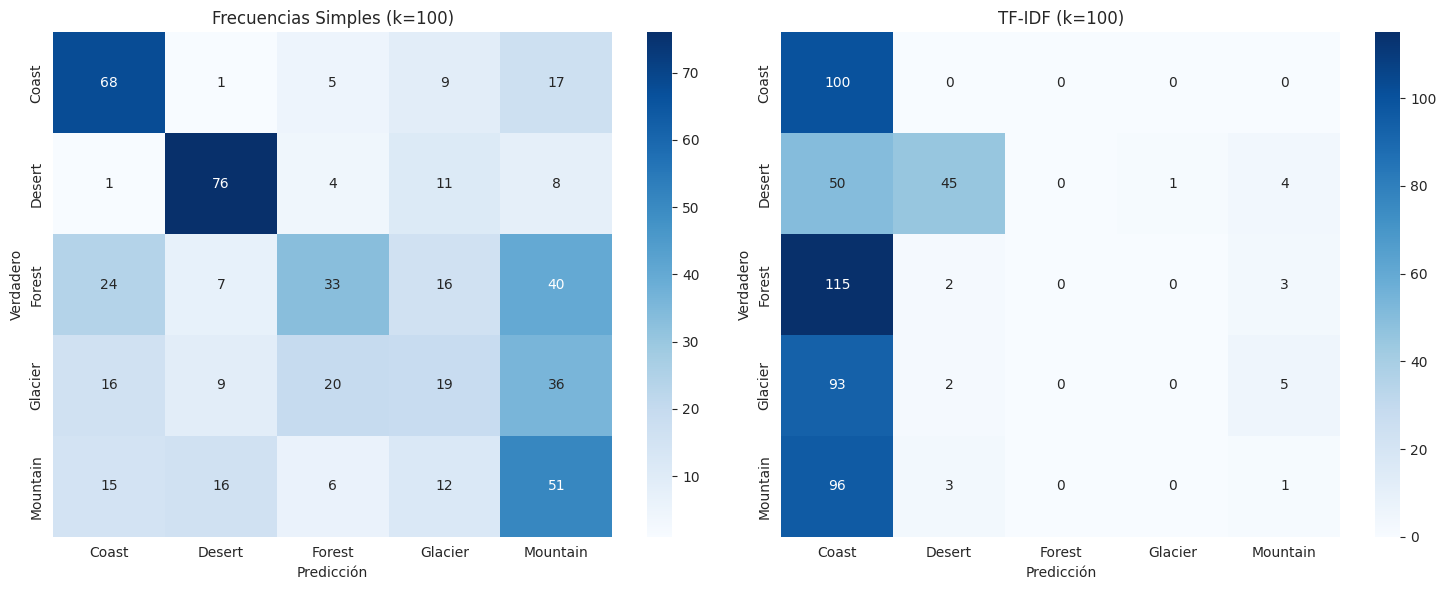

In [ ]:
plotConfusionMatrices(resultados_experimentos, K_final, metodos)

#### ***2) Análisis de Errores***

- ¿Qué categorías o ambientes se confunden más entre sí?
- ¿Por qué creen que ocurre esa confusión?
  - Ejemplos: similitud visual, baja representación de datos, condiciones de iluminación.

In [ ]:
errores = analizar_errores(resultados_experimentos, 'bow', test_subset)
imprimirErrores(errores, K_final, 'bow', len(test_subset['etiquetas']))


🔍 ANÁLISIS DE ERRORES (BOW, k=100)
--------------------------------------------------
Total de errores: 273 de 520 imágenes
Accuracy: 0.475

📊 CONFUSIONES MÁS COMUNES:
  Glacier → Coast: 40 casos
  Mountain → Coast: 36 casos
  Glacier → Desert: 24 casos
  Mountain → Glacier: 20 casos
  Desert → Coast: 17 casos
  Glacier → Mountain: 16 casos
  Mountain → Desert: 16 casos
  Coast → Forest: 16 casos
  Coast → Desert: 15 casos
  Coast → Mountain: 12 casos
  Forest → Mountain: 11 casos
  Desert → Mountain: 9 casos
  Mountain → Forest: 9 casos
  Forest → Coast: 8 casos
  Glacier → Forest: 7 casos
  Coast → Glacier: 6 casos
  Desert → Glacier: 5 casos
  Forest → Glacier: 4 casos
  Desert → Forest: 1 casos
  Forest → Desert: 1 casos



#### ***3) Ejemplos Específicos***

Muestren al menos **2 o 3 ejemplos concretos** donde el sistema se equivoca:

- Etiqueta verdadera vs. predicción
- Comentario sobre el posible motivo del error

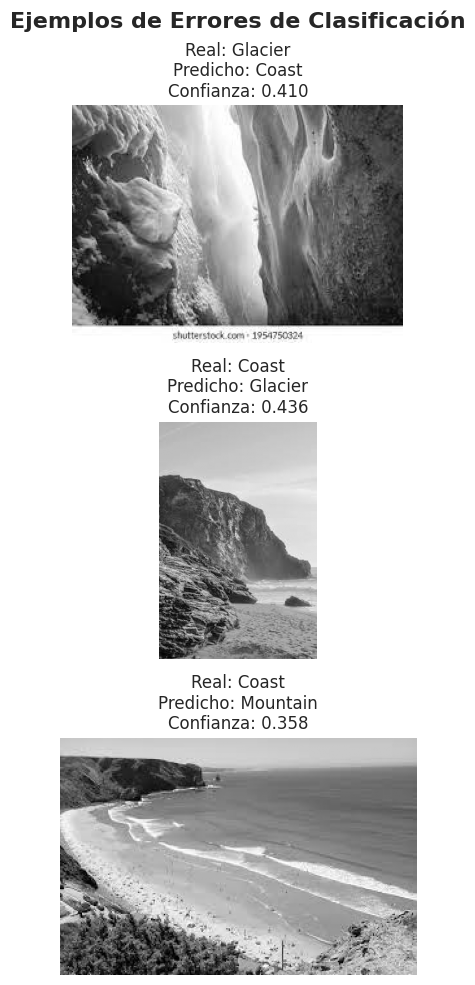

In [ ]:
mostrarEjemplosErrores(errores, n_ejemplos=3)

Algunas imagenes del ejemplo tienen sentido que se parezcan

Por ejemplo,
La 1er iamgen no parece un glaciar a simple vista
La 2da imagen se puede equivocar con glaciares sacados desde abajo
La ultima imagen mantiene una forma de acantilado, con lo cual e sposibles que se equivoque con montañas

#### ***4) Visualizaciones***

Escriban visualizaciones que ayuden a interpretar el comportamiento del sistema:

- **Distribución de palabras visuales por categoría**
- **Keypoints más característicos** por clase

In [ ]:
def plot_palabras_visuales_por_categoria(representaciones_bow, etiquetas):
  categorias = list(set(etiquetas))
  k = representaciones_bow.shape[1]

  distribuciones_por_categoria = {}

  for categoria_actual in categorias:
    indices = [indice for indice, etiqueta in enumerate(etiquetas) if etiqueta == categoria_actual]
    distribucion_categoria = representaciones_bow[indices].sum(axis=0)
    distribuciones_por_categoria[categoria_actual] = distribucion_categoria

  plt.figure(figsize=(12,6))
  for categoria_actual in categorias:
      plt.plot(distribuciones_por_categoria[categoria_actual], label=f"Clase {categoria_actual}")

  plt.title("Distribución de palabras visuales por categoría")
  plt.xlabel("Palabra visual")
  plt.ylabel("Frecuencia total")
  plt.legend()
  plt.show()

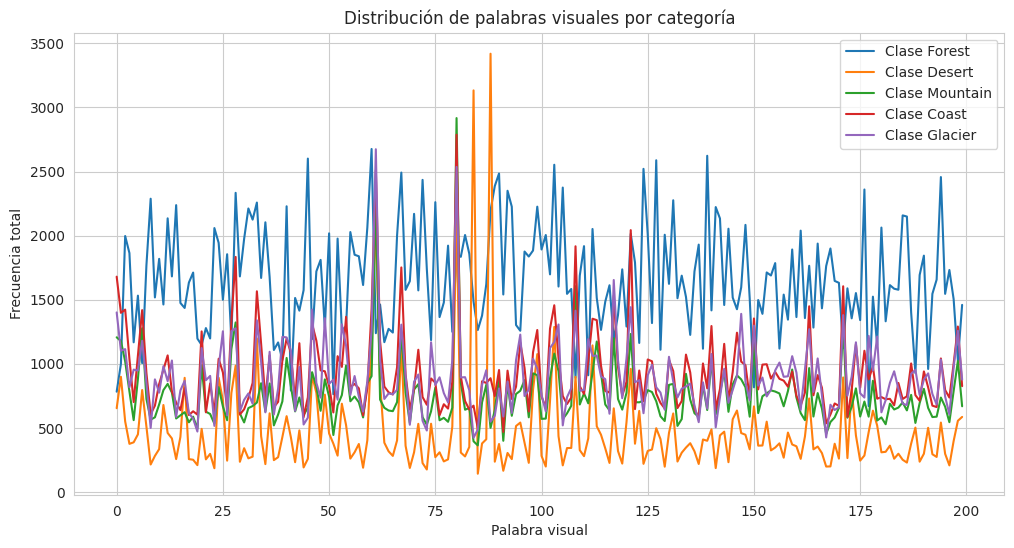

In [ ]:
plot_palabras_visuales_por_categoria(representaciones_bow, training_subset['etiquetas'])

In [ ]:
def obtener_top_palabras_visuales(representaciones_bow, etiquetas, n_top=5):
  categorias = list(set(etiquetas))
  top_palabras_por_clase = {}

  for categoria_actual in categorias:
      indices = [indice for indice, etiqueta in enumerate(etiquetas) if etiqueta == categoria_actual]
      distribucion_categoria = representaciones_bow[indices].sum(axis=0)

      frecuencia_total_categoria = float(distribucion_categoria.sum())

      top_indices = np.argsort(distribucion_categoria)[-n_top:][::-1]
      top_frecuencias = distribucion_categoria[top_indices]


      tuplas_keypoint_frecuencia = []
      for keypoint_id, frecuencia in zip(top_indices, top_frecuencias):
          representacion_porcentual = (frecuencia / frecuencia_total_categoria) * 100
          tuplas_keypoint_frecuencia.append((int(keypoint_id), float(frecuencia), float(representacion_porcentual)))

      top_palabras_por_clase[categoria_actual] = {
          'tuplas_top': tuplas_keypoint_frecuencia,
          'frecuencia_total': frecuencia_total_categoria
      }

  return top_palabras_por_clase

In [ ]:
def top_palabras_a_dataframe(top_palabras_por_clase):

    filas = []

    for categoria, datos in top_palabras_por_clase.items():
        frecuencia_total = datos['frecuencia_total']

        for posicion_top, (keypoint, frecuencia, porcentaje) in enumerate(datos['tuplas_top'], 1):
            filas.append({
                'Categoría': categoria,
                'posicion_top': posicion_top,
                'Keypoint_ID': keypoint,
                'Frecuencia': int(frecuencia),
                'Porcentaje_Categoría (%)': round(porcentaje,2)
            })

    df = pd.DataFrame(filas)
    return df

In [ ]:
datos_palabras =obtener_top_palabras_visuales(representaciones_bow, training_subset['etiquetas'])

In [ ]:
dataframe_top_palabras =top_palabras_a_dataframe(datos_palabras)

In [ ]:
dataframe_top_palabras

Categoría  posicion_top  Keypoint_ID  Frecuencia  Porcentaje_Categoría (%)
0     Forest             1           60        2676                      0.81
1     Forest             2          139        2623                      0.79
2     Forest             3           45        2601                      0.78
3     Forest             4          127        2588                      0.78
4     Forest             5          103        2553                      0.77
5     Desert             1           88        3419                      3.59
6     Desert             2           84        3133                      3.29
7     Desert             3           80        2181                      2.29
8     Desert             4           61        2103                      2.21
9     Desert             5          103        1288                      1.35
10  Mountain             1           80        2917                      1.93
11  Mountain             2           61        2293                      1.52
12  Mountain             3          108        1606                      1.06
13  Mountain             4           28        1323                      0.88
14  Mountain             5          171        1300                      0.86
15     Coast             1           80        2787                      1.51
16     Coast             2           61        2511                      1.36
17     Coast             3          121        2043                      1.10
18     Coast             4          108        1917                      1.04
19     Coast             5           28        1834                      0.99
20   Glacier             1           61        2674                      1.49
21   Glacier             2           80        2536                      1.42
22   Glacier             3          117        1654                      0.92
23   Glacier             4          121        1442                      0.81
24   Glacier             5           46        1423                      0.80

In [ ]:
keypoints_compartidos = dataframe_top_palabras.groupby('Keypoint_ID').agg({
        'Categoría': ['count', lambda x: list(x)]}).round(2)


keypoints_compartidos.columns = ['Apariciones', 'Categorías']

keypoints_repetidos = keypoints_compartidos[keypoints_compartidos['Apariciones'] > 1]
keypoints_repetidos = keypoints_repetidos.sort_values('Apariciones', ascending=False)

In [ ]:
keypoints_repetidos

Apariciones                          Categorías
Keypoint_ID                                                 
61                     4  [Desert, Mountain, Coast, Glacier]
80                     4  [Desert, Mountain, Coast, Glacier]
28                     2                   [Mountain, Coast]
103                    2                    [Forest, Desert]
108                    2                   [Mountain, Coast]
121                    2                    [Coast, Glacier]

#### ***5) Limitaciones Observadas***

Describan **2 o 3 limitaciones** del sistema:

- ¿En qué tipos de imágenes o ambientes tiende a fallar?
- ¿Qué factores afectan negativamente el rendimiento?

Fotos muy diversas entre si, Keypoints compartidos

In [ ]:
def mostrar_imagen_de_test(imagen_indice):
  imagen = imagenes_test[imagen_indice]
  categoria_real = etiquetas_test[imagen_indice]

  fig, ax = plt.subplots(figsize=(6,6))
  ax.imshow(imagen, cmap='gray')
  ax.set_title(f"Imagen de Test, etiqueta : {categoria_real}")
  ax.axis('off')
  plt.show()


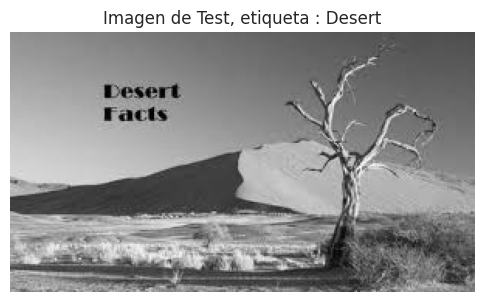

In [ ]:
mostrar_imagen_de_test(0)

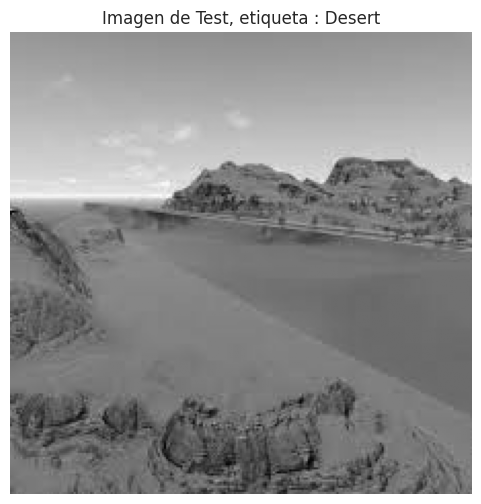

In [ ]:
mostrar_imagen_de_test(1)

Una limitación es que las imagenes tienen muchos keypoints iguales (como se puede observar en el dataframe del ejercio anterior). Con lo cual al no haber una especie de restricción o penalización en las distribuciones, es normal que se equivoque.


Por otro laod, como vemos en las imagenes anteriores las imagenes son muy diversas entre si en su propia clase. Con lo cual, no hay una representación unica para cada una y aumenta la invarianza entre ellas, impiediendo una generalización.

#### ***6) Propuestas de Mejora***

Propongan al menos **2 o 3 ideas concretas** para mejorar el sistema. Por ejemplo:

- Inclusión de color o textura como información adicional
- Cambiar el clasificador (Random Forest, redes neuronales)
- Limpieza del dataset
- etc


Una de las ideas es añadir los valores de cada pixeles en RGB, para que se observe mejor las diferencias entre ellas (por ejemplo, entre desierto y glaciares).

Por otro lado, como se mencionó anteriormente seria buna idea añadir una penalización a los keypoints mas frecuentes para enocntrar las palabras visuales caracteristicas de cada uno.


Por último, Seria bueno añadir subclases a cada imagen para una mayor generalización (por ejemplo, crear subclase imagen con camellos para desiertos,o algun tipo de flora caracteristico). Además, limpiar los datasets, para uqe no haya imagenes artificales (como sucede en la imagen de test de indice 0, donde vemos que hay palabras sobre la imagen que pueden ser consideradas como keypoints).